In [1]:
#statistical analysis
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.regression.rolling import RollingOLS
from statsmodels.iolib.summary2 import summary_col
from arch import arch_model
from arch.univariate import ARCHInMean, GARCH, StudentsT, Normal
from scipy.stats import norm
from scipy.optimize import minimize

#machine learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC


#data visualization
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from matplotlib.ticker import FuncFormatter

import seaborn as sns

#other
from io import StringIO
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Data

In [2]:
# RUTAS

#Rancagua
R_DATA_1 = r"C:\Users\feder\Documents\GitHub\PROYECTS\MAX_RETURN_REG\DATA\DATA_1.xlsx"
R_DATA_2 = r"C:\Users\feder\Documents\GitHub\PROYECTS\MAX_RETURN_REG\DATA\DATA_2.xlsx"

# #Santiago
# R_DATA_1 = r"C:\Users\feder\OneDrive - Universidad Adolfo Ibanez\Tesis - Workshop\DATA\DATA_1.xlsx"
# R_DATA_2 = r"C:\Users\feder\OneDrive - Universidad Adolfo Ibanez\Tesis - Workshop\DATA\DATA_2.xlsx"

data = """Asset,Descripción,Ticker Bloomberg,Notas
GC,Oro,GC1:COM,Metal precioso
SI,Plata,SI1:COM,Metal precioso
PL,Platino,PL1:COM,Metal precioso
PA,Paladio,PA1:COM,Metal precioso
Aluminio,LME 3M,LMAHDS03 Comdty,Metal industrial
Aleación Aluminio,LME 3M,LMAADS03 Comdty,Metal industrial
Cobre,LME 3M,LMCADS03 Comdty,Metal industrial
Plomo,LME 3M,LMPBDS03 Comdty,Metal industrial
Níquel,LME 3M,LMNIDS03 Comdty,Metal industrial
Estaño,LME 3M,LMSNDS03 Comdty,Metal industrial
Zinc,LME 3M,LMZSDS03 Comdty,Metal industrial
NASAAC,LME 3M,LMNADS03 Comdty,Metal industrial
WTI Crude Oil,Futuro genérico 1,CL1:COM,
Brent Crude Oil,Futuro genérico 1,CO1:COM,
RBOB Gasoline,Futuro genérico 1,XB1:COM,
Heating Oil,Futuro genérico 1,HO1:COM,
Natural Gas,Futuro genérico 1,NG1:COM,
Gasoil,Futuro genérico 1,QS1:COM,
Kerosene (Tokyo),Contrato,JX1:COM,
Crack Spread 3-2-1,Spread estándar,CRKS321 Index,Disponible en Bloomberg
Crack Spot Spread (CSS),Spread gasolina/heating oil vs crudo,,Construir en Excel
Crude Oil Futures Spot Spread (FSS),Futuro vs spot,,Construir en Excel
Basis,Diferencia futuros 1er y 2do mes,,Construir en Excel
GOP,Global crude oil production,,EIA
GOI,Global crude oil inventory,,EIA+OECD
REA,Global real economic activity,,Índice Kilian (fletes marítimos)
INFL,Inflación US CPI,,FRED o Bloomberg Econ
TBL,3M Treasury Bill Rate,,FRED/Bloomberg
M1,M1 Money Stock,,FRED
M2,M2 Money Stock,,FRED
RIND,CRB Industrial Raw Material Index,,CRB provider
METL,CRB Metal Price Index,,CRB provider
XOI,NYSE Oil & Gas Index,XOI Index,
NYA,NYSE Composite Index,NYA Index,
"""
from io import StringIO
df = pd.read_csv(StringIO(data))

print("DATA que deberiamos tener:")
display(df)

#CARGAR DATA MENSUAL
MONTHLY_DF1 = pd.read_excel(R_DATA_1, sheet_name='DATA_OFFLINE')

#Drop first 4 rows
MONTHLY_DF1 = MONTHLY_DF1.drop(index=[0,1,3,4,5]).reset_index(drop=True)

#Set first row as header and drop it from data
MONTHLY_DF1.columns = MONTHLY_DF1.iloc[0]
MONTHLY_DF1 = MONTHLY_DF1.drop(index=[0]).reset_index(drop=True)

#Set firt column as index and drop it from data.
MONTHLY_DF1 = MONTHLY_DF1.set_index(MONTHLY_DF1.columns[0])

#Label index as "DATE"
MONTHLY_DF1.index.name = 'DATE'

#Set index as datetime
MONTHLY_DF1.index = pd.to_datetime(MONTHLY_DF1.index, format='%d/%m/%Y')

# Drop duplicated columns
MONTHLY_DF1 = MONTHLY_DF1.loc[:,~MONTHLY_DF1.columns.duplicated()]

MONTHLY_DF1

#CARGAR DATA DIARIA
DAILY_DF = pd.read_excel(R_DATA_2, sheet_name="DATA_OFFLINE")

#Hacemos columa "Dates"
DAILY_DF["Dates"] = pd.to_datetime(DAILY_DF["Dates"], format='%d/%m/%Y')

#Establecemos la columna "Dates" como índice
DAILY_DF.set_index("Dates", inplace=True)

# Missing values: Last observation carried forward, just one day forward
DAILY_DF.fillna(method="ffill",axis=0, inplace=True, limit=2)

#MOUNTHLY_DF: Last Observation of the month
MONTHLY_DF2 = DAILY_DF.loc[MONTHLY_DF1.index.intersection(DAILY_DF.index)]

# Drop columns with the same data
MONTHLY_DF2 = MONTHLY_DF2.loc[:,~MONTHLY_DF2.T.duplicated(keep='first')]

MONTHLY_DF2

#DATA_1 LABLES
DAILY_DF_LABLES = pd.read_excel(R_DATA_2, sheet_name="DATA_NAME_OFFLINE")


DAILY_DF_LABLES["FULL NAME"][DAILY_DF_LABLES["TICKER"] == "HO2 Comdty"].values[0]

DAILY_DF_LABLES["TICKER"].values

DAILY_DF_LABLES

#Check if they share the index
if not MONTHLY_DF1.index.equals(MONTHLY_DF2.index):
    print("DataFrames do not share the same index.")

#Check every column of both DF if they are the same
columns_monthly_1 = set(MONTHLY_DF1.columns)
columns_monthly_2 = set(MONTHLY_DF2.columns)

# Find common columns
common_columns = columns_monthly_1.intersection(columns_monthly_2)
print(f"Common columns: {common_columns}")

# Check if they are the same: percentage of similarity of each column with respect to the first DataFrame

discrepancies = {}
for col in common_columns:
    comp = np.array(MONTHLY_DF1[col]) == np.array(MONTHLY_DF2[col])
    mean_distance_percentage = (np.abs(MONTHLY_DF1[col] - MONTHLY_DF2[col])/MONTHLY_DF1[col]).mean()

    similarity_percentage = comp.mean() * 100  # share of matches in percent

    if similarity_percentage == 100:
        continue
    else:
        print(f"Discrepancy for column '{col}': {similarity_percentage:.2f}%, Mean Absolute Difference: {mean_distance_percentage:.4f}")
        discrepancies[col] = similarity_percentage

DAILY_DF_LABLES["TICKER"].values

DAILY_DF_LABLES["FULL NAME"].values

NEW_NAMES = {
"MSCI World/Metals&Mining": "MSCI_Metals",
"MSCI WRLD CMMDTY PRD NR": "MSCI_Commodities",
"WTI CRUDE FUTURE  Oct25": "WTI_Crude_Oct25",
"Generic 1st 'CL' Future": "WTI_Crude_G1",
"W&T OFFSHORE INC": "W&T_Offshore",
"WTI CRUDE FUTURE  Oct25": "WTI_Crude_Oct25",
"Generic 2nd 'HO' Future": "Heating_Oil_G2",
"WTI CRUDE FUTURE  Nov25": "WTI_Crude_Nov25",
"NY Harb ULSD Fut  Oct25": "ULSD_Oct25",
"Generic 1st 'HG' Future": "Copper_G1",
"Generic 1st 'CO' Future": "Brent_Oil_G1",
"Generic 1st 'GC' Future": "Gold_G1",
"Generic 1st 'SI' Future": "Silver_G1",
"Generic 1st 'PL' Future": "Platinum_G1",
"Generic 1st 'LA' Future": "Aluminum_G1",
"Generic 1st 'LY' Future": "LME_Alloy_G1",
"LME COPPER    3MO ($)": "LME_Copper",
"LME LEAD      3MO ($)": "LME_Lead",
"Generic 1st 'LL' Future": "Lumber_G1",
"LME NICKEL    3MO ($)": "LME_Nickel",
"Generic 1st 'LN' Future": "LME_Nickel_G1",
"LME TIN       3MO ($)": "LME_Tin",
"Generic 1st 'LT' Future": "LME_Tin_G1",
"LME ZINC      3MO ($)": "LME_Zinc",
"Generic 1st 'LX' Future": "LME_Zinc_G1",
"LME NASAAC 3MO ($)": "LME_NASAAC",
"Generic 1st 'LK' Future": "LME_Cobalt_G1",
"Generic 1st 'XB' Future": "Battery_Nickel_G1",
"Generic 1st 'QS' Future": "Uranium_G1",
"Generic 1st 'NG' Future": "Nat_Gas_G1",
"Generic 1st 'JX' Future": "Jet_Fuel_G1",
"Generic 1st 'XO' Future": "Gasoline_G1",
"NYSE COMPOSITE INDEX": "NYSE_Index",
"Generic 1st 'KG' Future": "Krypton_Gas_G1",
"XBT-USD Cross Rate": "BTC/USD",
"XET-USD Cross Rate": "ETH/USD",
"XLC-USD Cross Rate": "LTC/USD",
"XRP-USD Cross Rate": "XRP/USD",
"XDT-USD Cross Rate": "DOT/USD",
"XBI-USD Cross Rate": "BCH/USD",
"XSO-USD Cross Rate": "SOL/USD",
"XBT-USD Cross Rate": "BTC/USD",
"XDG-USD Cross Rate": "DOGE/USD",
"XTR-USD Cross Rate": "TRON/USD",
"XAD-USD Cross Rate": "ADA/USD",
"AUD-USD X-RATE": "AUD/USD",
"CAD-USD X-RATE": "CAD/USD",
"NZD-USD X-RATE": "NZD/USD",
"NOK-USD X-RATE": "NOK/USD",
"BRL-USD X-RATE": "BRL/USD",
"Russian Ruble SPOT (TOM)": "RUB/USD",
"ZAR-USD X-RATE": "ZAR/USD",
"CLP-USD X-RATE (x100)": "CLP/USD",
"CNH-USD Cross Rate": "CNH/USD",
"EUR-USD X-RATE": "EUR/USD",
"SGD-USD X-RATE": "SGD/USD",
"INR-USD X-RATE": "INR/USD",
"AED-USD X-RATE": "AED/USD",
"SAR-USD X-RATE": "SAR/USD",
"COPPER FUTURE     Dec25": "Copper_Dec25",
"LME PRI ALUM FUTR Nov25": "Aluminum_Nov25",
"LME LEAD FUTURE   Nov25": "Lead_Nov25",
"LME NICKEL FUTURE Nov25": "Nickel_Nov25",
"LME ZINC FUTURE   Nov25": "Zinc_Nov25",
"Generic 1st 'C ' Future": "Corn_G1",
"Generic 1st 'W ' Future": "Wheat_G1",
"Generic 1st 'RR' Future": "Rice_G1",
"Generic 1st 'S ' Future": "Soybeans_G1",
"Generic 1st 'SM' Future": "Soymeal_G1",
"Generic 1st 'BO' Future": "Soy_Oil_G1",
"Generic 1st 'RS' Future": "Rapeseed_G1",
"LMEX LONDON METALS INDEX": "LMEX_Index"
}

NEW_NAMES.get("Generic 1st 'RS' Future")

#Retono 1 mes
DF_RENT = np.log(MONTHLY_DF2).diff(1)

# Rename columns using NEW_NAMES dict, handling cases where full name is not found or multiple matches
new_columns = []
for col in DF_RENT.columns:
	matching_full_names = DAILY_DF_LABLES["FULL NAME"][DAILY_DF_LABLES["TICKER"] == col]
	if not matching_full_names.empty:
		full_name = matching_full_names.iloc[0]  # Take the first match
		new_name = NEW_NAMES.get(full_name, col)  # Use NEW_NAMES if available, else keep original col
	else:
		new_name = col  # No match, keep original
	new_columns.append(new_name)

BASE_COLUMNS = new_columns

DF_RENT.columns = ["R1_" + col for col in BASE_COLUMNS]


#RCLP6: Negativo del retorno semestral mensuaizado (t-1)
DF_RENT["R6_CLP/USD"] = -np.log(MONTHLY_DF2['CLPUSD Curncy']).diff(6)/6

#RCLP2: Negativo del retorno bimestral mensuaizado (t-1)
DF_RENT["R2_CLP/USD"] = -np.log(MONTHLY_DF2['CLPUSD Curncy']).diff(2)/2

#RCLP8: Negativo del retorno bitrimestral mensualisado (t-1)
DF_RENT["R8_CLP/USD"] = -np.log(MONTHLY_DF2['CLPUSD Curncy']).diff(8)/8

#RMSCI2: Retorno logaritmico bimestral mensualisado (t-1)
DF_RENT["R2_MSCI_Commodities"] = np.log(MONTHLY_DF2['M1WO0CMP Index']).diff(2)/2


DF_RENT

#Retono 1 mes
# Asegurar numérico antes de aplicar log para evitar TypeError
_numeric_monthly_df1 = MONTHLY_DF1.apply(pd.to_numeric, errors='coerce')
DF_RENT2 = np.log(_numeric_monthly_df1).diff(1)

# Rename columns using NEW_NAMES dict, handling cases where full name is not found or multiple matches
new_columns = []
for col in DF_RENT2.columns:
	matching_full_names = DAILY_DF_LABLES["FULL NAME"][DAILY_DF_LABLES["TICKER"] == col]
	if not matching_full_names.empty:
		full_name = matching_full_names.iloc[0]  # Take the first match
		new_name = NEW_NAMES.get(full_name, col)  # Use NEW_NAMES if available, else keep original col
	else:
		new_name = col  # No match, keep original
	new_columns.append(new_name)

BASE_COLUMNS = new_columns

# Renombrar correctamente DF_RENT2 (no DF_RENT)
DF_RENT2.columns = ["R1_" + col for col in BASE_COLUMNS]

# RCLP*: usar la columna disponible (CLPUSD Curncy o CLP Curncy) y datos numéricos
fx_col = next((c for c in ['CLPUSD Curncy', 'CLP Curncy'] if c in MONTHLY_DF1.columns), None)
if fx_col is not None:
	DF_RENT2["R6_CLP/USD"] = -np.log(_numeric_monthly_df1[fx_col]).diff(6) / 6
	DF_RENT2["R2_CLP/USD"] = -np.log(_numeric_monthly_df1[fx_col]).diff(2) / 2
	DF_RENT2["R8_CLP/USD"] = -np.log(_numeric_monthly_df1[fx_col]).diff(8) / 8

# R2_MSCI_Commodities: intentar con columnas alternativas si existen
msci_col = next((c for c in ['M1WO0CMP Index', 'MXWO0MM Index'] if c in MONTHLY_DF1.columns), None)
if msci_col is not None:
	DF_RENT2["R2_MSCI_Commodities"] = np.log(_numeric_monthly_df1[msci_col]).diff(2) / 2

DF_RENT2


DATA que deberiamos tener:


,Asset,Descripción,Ticker Bloomberg,Notas
0,GC,Oro,GC1:COM,Metal precioso
1,SI,Plata,SI1:COM,Metal precioso
2,PL,Platino,PL1:COM,Metal precioso
3,PA,Paladio,PA1:COM,Metal precioso
4,Aluminio,LME 3M,LMAHDS03 Comdty,Metal industrial
5,Aleación Aluminio,LME 3M,LMAADS03 Comdty,Metal industrial
6,Cobre,LME 3M,LMCADS03 Comdty,Metal industrial
7,Plomo,LME 3M,LMPBDS03 Comdty,Metal industrial
8,Níquel,LME 3M,LMNIDS03 Comdty,Metal industrial
9,Estaño,LME 3M,LMSNDS03 Comdty,Metal industrial


Common columns: {'BO1 Comdty', 'NG1 Comdty', 'CO1 Comdty', 'LMNADS03 Comdty', 'LMSNDS03 Comdty', 'XDTUSD Curncy', 'LMCADS03 Comdty', 'C 1 Comdty', 'LMPBDS03 Comdty', 'RR1 Comdty', 'GC1 Comdty', 'XADUSD Curncy', 'XB1 Comdty', 'QS1 Comdty', 'XRPUSD Curncy', 'XSOUSD Curncy', 'XLCUSD Curncy', 'PL1 Comdty', 'XETUSD Curncy', 'SI1 Comdty', 'XBTUSD Curncy', 'S 1 Comdty', 'CL1 Comdty', 'LMZSDS03 Comdty', 'SM1 Comdty', 'RS1 Comdty', 'XDGUSD Curncy', 'JX1 Comdty', 'W 1 Comdty', 'XBIUSD Curncy', 'LMNIDS03 Comdty', 'NYA Index'}
Discrepancy for column 'BO1 Comdty': 0.00%, Mean Absolute Difference: 0.9900
Discrepancy for column 'NG1 Comdty': 99.53%, Mean Absolute Difference: 0.0000
Discrepancy for column 'LMNADS03 Comdty': 65.96%, Mean Absolute Difference: 0.0000
Discrepancy for column 'XDTUSD Curncy': 16.90%, Mean Absolute Difference: 0.0003
Discrepancy for column 'C 1 Comdty': 0.00%, Mean Absolute Difference: 0.9900
Discrepancy for column 'RR1 Comdty': 99.53%, Mean Absolute Difference: 0.0000
Discr

,R1_Gold_G1,R1_Silver_G1,R1_Platinum_G1,R1_PA1 Comdty,R1_LMAHDS03 Comdty,R1_LMAADS03 Comdty,R1_LME_Copper,R1_LME_Lead,R1_LME_Nickel,R1_LME_Tin,...,R1_Corn_G1,R1_Wheat_G1,R1_Rice_G1,R1_Soybeans_G1,R1_Soymeal_G1,R1_Soy_Oil_G1,R1_Rapeseed_G1,R6_CLP/USD,R2_CLP/USD,R8_CLP/USD
DATE,,,,,,,,,,,,,,,,,,,,,
1990-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-03-30,-0.099427,-0.029091,-0.068220,0.027345,0.061889,NaN,0.064085,0.073937,0.187862,0.046660,...,0.056089,-0.111525,0.003805,0.049084,0.056919,0.039728,0.021756,NaN,NaN,NaN
1990-04-30,0.003236,-0.009685,-0.000843,-0.100449,-0.040611,NaN,-0.047634,0.012157,-0.036572,-0.045120,...,0.073766,0.062003,0.000000,0.060921,0.069730,0.060198,0.022735,NaN,-0.002939,NaN
1990-05-31,-0.019302,0.035455,0.040510,-0.002987,0.039347,NaN,0.017072,0.017938,-0.041539,0.000000,...,-0.011623,-0.114532,-0.010178,-0.040542,-0.032573,0.007223,-0.045094,NaN,0.000708,NaN
1990-06-29,-0.012151,-0.044621,-0.017573,0.005540,-0.004437,NaN,0.023225,0.108463,0.041539,-0.068444,...,0.061048,-0.024262,0.021506,0.026408,0.012824,0.050764,-0.022562,NaN,-0.000253,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-31,0.091937,0.103145,0.073765,0.106394,-0.028220,0.108884,0.036925,0.009739,0.030942,0.157276,...,0.008235,0.000000,0.021226,0.003208,0.003422,0.030765,-0.036706,-0.009441,0.015105,-0.001246
2025-04-30,0.060964,-0.061978,-0.040731,-0.068550,-0.054144,-0.019732,-0.062138,-0.027461,-0.031915,-0.156127,...,0.021634,-0.045722,-0.047152,0.019518,-0.009267,0.078997,0.108067,0.002430,0.007794,-0.005073
2025-05-30,-0.009140,0.015192,0.084524,0.028382,0.018376,0.000000,0.040063,0.000255,-0.011809,-0.030511,...,-0.051040,0.040120,0.041610,0.006742,0.021492,-0.035407,0.041197,0.004863,0.002847,-0.006369


# Upper Geo Mean Regression (UGM)

In [3]:
# ===============================================================
# Upper Geo Mean Regression (UGM) — versión monolítica COHERENTE
# ===============================================================
# Cambios clave de coherencia:
# - ¡ARREGLO CRÍTICO! Las predicciones ahora SIEMPRE se hacen vía Pipeline:
#       y_pred = pipeline.decision_function(X)
#   (antes se llamaba al estimador final directamente y se saltaba el scaler)
# - coverage_report y df_eval usan pipeline.decision_function.
# - Chequeos de orden de columnas y documentación de escala de betas.
# - Resto: P/R o fecha para el split; horizon; init del intercepto; metrics OOS indexadas.
# ===============================================================

from __future__ import annotations
import numpy as np
import pandas as pd
from typing import Iterable, Optional, Dict, Tuple, Callable, List, Union

from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# ==========================
# 1) Métricas
# ==========================
def Geo_mean_return(y_pred: np.ndarray, y_true: np.ndarray):
    y_pred = np.asarray(y_pred, float).reshape(-1)
    y_true = np.asarray(y_true, float).reshape(-1)
    if np.any(y_true <= -1.0):
        raise ValueError("Todos los retornos simples (y_true) deben ser > -1.")
    r = np.sign(y_pred) * y_true
    log_returns = np.log1p(r)
    geo_mean = (np.exp(np.mean(log_returns)) - 1.0) * 100.0
    mask_up  = y_pred > 0
    mask_low = y_pred < 0
    upper_geo_mean = (np.exp(np.mean(log_returns[mask_up]))  - 1.0) * 100.0 if np.any(mask_up)  else np.nan
    lower_geo_mean = (np.exp(np.mean(log_returns[mask_low])) - 1.0) * 100.0 if np.any(mask_low) else np.nan
    return float(geo_mean), float(upper_geo_mean), float(lower_geo_mean)


def upper_geo_mean_cv_scorer(estimator, X, y) -> float:
    # IMPORTANTE: 'estimator' es el Pipeline; usa su decision_function (aplica scaler)
    y_pred = estimator.decision_function(X)
    _, ugm, _ = Geo_mean_return(y_pred, y)
    return -1e9 if np.isnan(ugm) else float(ugm)

# ==========================
# 2) Optimizadores
# ==========================
Array = np.ndarray
ObjFun = Callable[[Array], Tuple[float, Array, Dict[str, float]]]

def sigmoid_stable(z: Array) -> Array:
    z = np.asarray(z, float)
    pos = z >= 0
    out = np.empty_like(z)
    out[pos] = 1.0 / (1.0 + np.exp(-z[pos]))
    ez = np.exp(z[~pos])
    out[~pos] = ez / (1.0 + ez)
    return out

class GradientAscent:
    def __init__(self, max_iter=600, tol=1e-7, initial_step=1.0, c1=1e-4, verbose=False):
        self.max_iter = int(max_iter); self.tol = float(tol)
        self.initial_step = float(initial_step); self.c1 = float(c1)
        self.verbose = bool(verbose)

    def optimize(self, beta0: Array, f: ObjFun):
        beta = beta0.copy()
        J, g, extras = f(beta)
        hist = [{"J": float(J), "grad_norm": float(np.linalg.norm(g)), **extras}]
        for _ in range(self.max_iter):
            if np.linalg.norm(g) < self.tol: break
            step_k = self.initial_step; gg = float(g @ g); improved = False
            while step_k > 1e-12:
                beta_new = beta + step_k * g  # ASCENSO
                J_new, _, _ = f(beta_new)
                if J_new >= J + self.c1 * step_k * gg:
                    beta, J = beta_new, J_new; improved = True; break
                step_k *= 0.5
            if not improved: break
            J, g, extras = f(beta)
            hist.append({"J": float(J), "grad_norm": float(np.linalg.norm(g)), "step": float(step_k), **extras})
            if len(hist) >= 2:
                prev = hist[-2]["J"]
                if abs(J - prev) <= self.tol * (1e-12 + abs(prev)): break
        return beta, hist

def lbfgs_optimize(beta0: Array, f: ObjFun):
    try:
        from scipy.optimize import minimize
    except Exception as e:
        raise RuntimeError("scipy no disponible para L-BFGS-B") from e
    history = []
    def fun(x):
        J, g, extras = f(x)
        history.append({"J": float(J), "grad_norm": float(np.linalg.norm(g)), **extras})
        return -J, -g
    res = minimize(lambda v: fun(v)[0], beta0, jac=lambda v: fun(v)[1], method="L-BFGS-B")
    return res.x, history

# ==========================
# 3) Estimador
# ==========================
class UpperGeoMeanRegressorSK(BaseEstimator, RegressorMixin):
    def __init__(self,
                 fit_intercept: bool = True,
                 kappa: float = 8.0,
                 lam2: float = 1e-4,
                 eps_log: float = 1e-8,
                 eps_w: float = 1e-12,
                 max_iter: int = 1000,
                 tol: float = 1e-8,
                 step: float = 1.0,
                 verbose: bool = False,
                 anneal_schedule: Optional[Iterable[float]] = (0.5, 1.0, 2.0, 4.0),
                 random_state: Optional[int] = None,
                 pos_rate_target: float = 0.3,
                 pos_rate_weight: float = 20.0,
                 optimizer: str = 'auto',
                 init_from_pos_rate: bool = True):
        # No transformar parámetros (compat. sklearn.clone)
        self.fit_intercept = fit_intercept; self.kappa = kappa; self.lam2 = lam2
        self.eps_log = eps_log; self.eps_w = eps_w
        self.max_iter = max_iter; self.tol = tol; self.step = step; self.verbose = verbose
        self.anneal_schedule = anneal_schedule; self.random_state = random_state
        self.pos_rate_target = pos_rate_target; self.pos_rate_weight = pos_rate_weight
        self.optimizer = optimizer; self.init_from_pos_rate = init_from_pos_rate
        self.beta_ = None; self.intercept_ = None; self.coef_ = None; self.history_ = None

    def _augment(self, X: np.ndarray) -> np.ndarray:
        return np.c_[np.ones((X.shape[0], 1)), X] if self.fit_intercept else X

    def _objective_factory(self, X_aug: np.ndarray, y: np.ndarray, kappa: float):
        n = X_aug.shape[0]; lam2 = float(self.lam2); eps_log = float(self.eps_log)
        eps_w = float(self.eps_w); p0 = float(self.pos_rate_target); gamma = float(self.pos_rate_weight)
        fit_intercept = bool(self.fit_intercept)

        def f(beta: np.ndarray):
            eta = X_aug @ beta; z = kappa * eta
            s = np.tanh(z); w = sigmoid_stable(z)
            t = 1.0 + s * y; t_clipped = np.clip(t, eps_log, None)
            log_term = np.log1p(s * y); needs_clip = t <= eps_log
            if np.any(needs_clip): log_term = np.where(needs_clip, np.log(t_clipped), log_term)
            N = np.sum(w * log_term); D = np.sum(w) + eps_w; J_core = N / D
            pen = lam2 * np.sum(beta[1:] ** 2) if fit_intercept else lam2 * np.sum(beta ** 2)
            w_bar = (np.sum(w)) / n; cov_pen = gamma * (w_bar - p0) ** 2
            J = J_core - pen - cov_pen
            ds_deta = kappa * (1.0 - s**2); dlog_deta = ds_deta * (y / t_clipped)
            dwdeta = kappa * w * (1.0 - w)
            dN_deta = dwdeta * log_term + w * dlog_deta; dD_deta = dwdeta
            dJcore_deta = (D * dN_deta - N * dD_deta) / (D ** 2)
            dCov_deta = 2.0 * gamma * (w_bar - p0) * (dwdeta / n)
            grad_core = X_aug.T @ (dJcore_deta - dCov_deta)
            grad_pen = np.zeros_like(beta)
            if lam2 > 0:
                if fit_intercept: grad_pen[1:] = 2 * lam2 * beta[1:]
                else:             grad_pen = 2 * lam2 * beta
            grad = grad_core - grad_pen
            extras = {"J_core": float(J_core), "pen": float(pen), "cov_pen": float(cov_pen), "w_bar": float(w_bar)}
            return float(J), grad, extras
        return f

    def _optimize_once(self, X_aug: np.ndarray, y: np.ndarray, beta0: np.ndarray, kappa: float):
        f = self._objective_factory(X_aug, y, kappa)
        if self.optimizer in ('lbfgs', 'auto'):
            try: return lbfgs_optimize(beta0, f)
            except Exception: pass
        return GradientAscent(self.max_iter, self.tol, self.step, verbose=self.verbose).optimize(beta0, f)

    def fit(self, X: np.ndarray, y: np.ndarray):
        X = np.asarray(X, float); y = np.asarray(y, float).reshape(-1)
        if np.any(y <= -1.0): raise ValueError("Todos los retornos simples y deben ser > -1.")
        X_aug = self._augment(X)
        try:
            d = X_aug.shape[1]; ridge = 1e-6 * np.eye(d)
            beta0 = np.linalg.pinv(X_aug.T @ X_aug + ridge) @ X_aug.T @ y
        except Exception:
            beta0 = np.zeros(X_aug.shape[1])
        if self.fit_intercept and self.init_from_pos_rate:
            p0 = min(max(float(self.pos_rate_target), 1e-6), 1 - 1e-6)
            logit = np.log(p0 / (1 - p0)); kappa_safe = max(1.0, float(self.kappa))
            beta0[0] = logit / kappa_safe
        history = []; beta = beta0.copy()
        if self.anneal_schedule:
            for k in self.anneal_schedule:
                beta, hist_k = self._optimize_once(X_aug, y, beta, float(k)); history.extend(hist_k)
        beta, hist_k = self._optimize_once(X_aug, y, beta, float(self.kappa)); history.extend(hist_k)
        self.beta_ = beta
        if self.fit_intercept:
            self.intercept_ = float(beta[0]); self.coef_ = beta[1:].astype(float)
        else:
            self.intercept_ = 0.0; self.coef_ = beta.astype(float)
        self.history_ = history
        return self

    def decision_function(self, X: np.ndarray) -> np.ndarray:
        X = np.asarray(X, float)
        if self.beta_ is None: raise RuntimeError("Modelo no entrenado. Llama a .fit primero.")
        return (self.intercept_ + X @ self.coef_) if self.fit_intercept else (X @ self.coef_)

    def predict(self, X: np.ndarray) -> np.ndarray:
        return self.decision_function(X)

    def predict_sign(self, X: np.ndarray) -> np.ndarray:
        return np.sign(self.decision_function(X))

# ==========================
# 4) Utilidades + Pipeline
# ==========================
def build_lagged_dataset(
    df: pd.DataFrame,
    target_col: str,
    feature_cols: Optional[Iterable[str]] = None,
    lags: Iterable[int] | int = 1,
    horizon: int = 0,
) -> pd.DataFrame:
    df = df.sort_index()
    if feature_cols is None:
        feature_cols = [c for c in df.columns if c != target_col]
    if isinstance(lags, int): lags = [lags]
    if horizon < 0: raise ValueError("horizon debe ser >= 0")
    DATA = pd.DataFrame(index=df.index.copy())
    DATA["Y_simple"] = np.expm1(df[target_col].astype(float).shift(-horizon))
    for col in feature_cols:
        base = df[col].astype(float)
        for L in lags:
            if L < 0: raise ValueError("lags deben ser >= 0")
            DATA[f"{col}_lag{L}"] = base.shift(L)
    DATA = DATA.dropna()
    return DATA

def make_scaler(kind: str | None):
    kind = (kind or "standard").lower()
    if kind == "standard": return StandardScaler()
    if kind == "robust":   return RobustScaler()
    if kind == "quantile": return QuantileTransformer(output_distribution="normal", subsample=10_000, random_state=0)
    if kind in ("none", None): return None
    raise ValueError(f"Scaler desconocido: {kind}")

def build_pipeline(scaler: str | None = "standard", **ugm_params):
    steps = []; sc = make_scaler(scaler)
    if sc is not None: steps.append(("scaler", sc))
    steps.append(("ugm", UpperGeoMeanRegressorSK(**ugm_params)))
    return Pipeline(steps)

def _compute_split_positions(idx: pd.Index,
                             pr_ratio: Optional[float],
                             test_start: Optional[Union[str, pd.Timestamp]],
                             test_size: Optional[float]) -> Tuple[int, Dict]:
    T = len(idx)
    if T < 2: raise ValueError("Se requieren al menos 2 observaciones para split temporal.")
    if pr_ratio is not None:
        if pr_ratio <= 0: raise ValueError("pr_ratio debe ser > 0")
        R = int(np.floor(T / (1.0 + pr_ratio))); R = max(1, min(R, T - 1)); P = T - R
        i_te_start = R; pr_eff = P / R; start_dt = idx[i_te_start]
    elif test_start is not None:
        ts = pd.to_datetime(test_start)
        pos = int(np.searchsorted(idx.values, ts.to_datetime64(), side="left"))
        if pos <= 0 or pos >= T: raise ValueError("test_start fuera de rango tras preparar lags/NaNs.")
        R = pos; P = T - R; i_te_start = pos; pr_eff = P / R; start_dt = idx[i_te_start]
    else:
        if (test_size is None) or not (0.0 < test_size < 1.0):
            raise ValueError("Debes especificar pr_ratio, test_start o un test_size en (0,1).")
        R = int(np.floor((1.0 - test_size) * T)); R = max(1, min(R, T - 1)); P = T - R
        i_te_start = R; pr_eff = P / R; start_dt = idx[i_te_start]
    return i_te_start, {"T": T, "R": R, "P": P, "pr_ratio": float(pr_eff), "test_start_dt": pd.Timestamp(start_dt)}

def _coverage_from_eta(eta: np.ndarray, kappa: float) -> Dict[str, float]:
    w = 1.0 / (1.0 + np.exp(-kappa * eta))
    return {"frac_long": float(np.mean(eta > 0)), "w_bar": float(np.mean(w)), "eta_mean": float(np.mean(eta))}

def coverage_report(pipeline: Pipeline, X_tr: np.ndarray, X_te: np.ndarray, name: str = "UGM"):
    # ¡Usa el Pipeline para que aplique el scaler!
    def cov(X): 
        eta = pipeline.decision_function(X)
        ugm = pipeline.named_steps["ugm"]
        w = 1.0/(1.0 + np.exp(-ugm.kappa*eta))
        return float(np.mean(eta>0)), float(np.mean(w)), float(np.mean(eta))
    fr_tr, wbar_tr, eta_mean_tr = cov(X_tr); fr_te, wbar_te, eta_mean_te = cov(X_te)
    ugm = pipeline.named_steps["ugm"]
    print(f"[{name}] TRAIN  frac_long={fr_tr:.3f}  w_bar={wbar_tr:.3f}  mean(eta)={eta_mean_tr:.4f}")
    print(f"[{name}] TEST   frac_long={fr_te:.3f}  w_bar={wbar_te:.3f}  mean(eta)={eta_mean_te:.4f}")
    print(f"intercept={ugm.intercept_:.4f}  kappa={ugm.kappa}  implied_pos_rate≈{1/(1+np.exp(-ugm.kappa*ugm.intercept_)):.3f}")

def recover_original_params(pipeline: Pipeline):
    from sklearn.preprocessing import StandardScaler, RobustScaler
    ugm = pipeline.named_steps["ugm"]; b = float(ugm.intercept_); beta = ugm.coef_.astype(float)
    sc = pipeline.named_steps.get("scaler", None)
    if sc is None: return b, beta, "original"
    if isinstance(sc, StandardScaler):
        mu, scale = sc.mean_, sc.scale_
    elif isinstance(sc, RobustScaler):
        mu, scale = sc.center_, sc.scale_
    else:
        raise ValueError("Scaler no lineal (p.ej., QuantileTransformer): no se puede desescalar.")
    coef_orig = beta / scale; intercept_orig = b - np.sum(mu * coef_orig)
    return float(intercept_orig), coef_orig, "original"

def implied_pos_rate(intercept: float, kappa: float) -> float:
    return 1.0 / (1.0 + np.exp(-kappa * intercept))

def eta_from_pipeline(pipeline: Pipeline, DATA: pd.DataFrame) -> np.ndarray:
    X = DATA.drop(columns=["Y_simple"]).to_numpy(float)
    return pipeline.decision_function(X)

def eta_from_original_params(pipeline: Pipeline, DATA: pd.DataFrame) -> np.ndarray:
    X = DATA.drop(columns=["Y_simple"]).to_numpy(float)
    b0_orig, beta_orig, _ = recover_original_params(pipeline)
    return b0_orig + X @ beta_orig

def build_eval_panel_from_eta(DATA: pd.DataFrame, eta: np.ndarray) -> pd.DataFrame:
    y_true = pd.Series(DATA["Y_simple"].to_numpy(float), index=DATA.index, name="y_true")
    eta_s  = pd.Series(eta, index=DATA.index, name="eta")
    signal = np.sign(eta_s).rename("signal")
    strat  = (signal * y_true).rename("strategy_r")
    return pd.concat([y_true, eta_s, signal, strat], axis=1)

def run_upper_geo_pipeline(
    df: pd.DataFrame,
    target_col: str,
    feature_cols: Optional[Iterable[str]] = None,
    lags: Iterable[int] | int = 1,
    horizon: int = 0,
    pr_ratio: Optional[float] = None,
    test_start: Optional[Union[str, pd.Timestamp]] = None,
    test_size: Optional[float] = 0.2,
    cv_splits: int = 5,
    param_grid: Optional[Dict] = None,
    scaler: str | None = "standard",
    base_kappa: float = 8.0,
    base_lam2: float = 1e-4,
    anneal_schedule: Optional[Iterable[float]] = (0.5, 1.0, 2.0, 4.0),
    pos_rate_target: float = 0.3,
    pos_rate_weight: float = 20.0,
    optimizer: str = 'auto',
    random_state: Optional[int] = None,
):
    df = df.sort_index()
    DATA = build_lagged_dataset(df, target_col, feature_cols, lags, horizon=horizon)
    X = DATA.drop(columns=["Y_simple"]).to_numpy(dtype=float)
    y = DATA["Y_simple"].to_numpy(dtype=float)
    i_te_start, split_info = _compute_split_positions(DATA.index, pr_ratio, test_start, test_size)
    X_tr, X_te = X[:i_te_start], X[i_te_start:]; y_tr, y_te = y[:i_te_start], y[i_te_start:]
    idx_te = DATA.index[i_te_start:]

    pipe = build_pipeline(
        scaler=scaler, fit_intercept=True, kappa=base_kappa, lam2=base_lam2, max_iter=1000, tol=1e-8, step=1.0,
        anneal_schedule=anneal_schedule, pos_rate_target=pos_rate_target, pos_rate_weight=pos_rate_weight,
        optimizer=optimizer, random_state=random_state, init_from_pos_rate=True
    )

    cv = TimeSeriesSplit(n_splits=cv_splits)
    if param_grid is None:
        param_grid = {"ugm__kappa": [2.0, 4.0, 8.0], "ugm__lam2": [1e-6, 1e-5, 1e-4],
                      "ugm__pos_rate_target": [0.3, 0.4, 0.5], "ugm__pos_rate_weight": [10.0, 20.0, 40.0]}
    gs = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=upper_geo_mean_cv_scorer,
                      cv=cv, n_jobs=-1, refit=True)
    gs.fit(X_tr, y_tr)
    best_model = gs.best_estimator_

    # PREDICCIONES OOS: ¡por el Pipeline!
    y_pred_te = best_model.decision_function(X_te)
    geo, upper_geo, lower_geo = Geo_mean_return(y_pred_te, y_te)

    # Series OOS indexadas
    y_pred_te_s = pd.Series(y_pred_te, index=idx_te, name="eta_pred")
    y_te_s      = pd.Series(y_te, index=idx_te, name="y_true")
    signal_s    = np.sign(y_pred_te_s).rename("signal")
    strategy_r  = (signal_s * y_te_s).rename("strategy_r")
    df_eval     = pd.concat([y_te_s, y_pred_te_s, signal_s, strategy_r], axis=1)

    # Cobertura (TRAIN/TEST) utilizando el Pipeline
    eta_tr = best_model.decision_function(X_tr)
    cov_train = _coverage_from_eta(eta_tr, best_model.named_steps["ugm"].kappa)
    cov_test  = _coverage_from_eta(y_pred_te, best_model.named_steps["ugm"].kappa)

    # Betas (escala escalada) y, si aplica, a escala original
    ugm = best_model.named_steps["ugm"]
    beta_hat_scaled = np.r_[ugm.intercept_, ugm.coef_]
    scaler_step = best_model.named_steps.get("scaler", None)
    beta_hat_original = None
    try:
        b0_orig, beta_orig, _ = recover_original_params(best_model)
        beta_hat_original = np.r_[b0_orig, beta_orig]
    except Exception:
        pass

    feature_names = [c for c in DATA.columns if c != "Y_simple"]

    return {
        "best_model": best_model,
        "cv_best_score": float(gs.best_score_),
        "cv_best_params": gs.best_params_,
        "test_metrics": {"geo_mean": float(geo), "upper_geo_mean": float(upper_geo), "lower_geo_mean": float(lower_geo)},
        "coverage_train": cov_train, "coverage_test": cov_test,
        "split_info": split_info, "feature_names": feature_names,
        "X_tr": X_tr, "y_tr": y_tr, "X_te": X_te, "y_te": y_te,
        "y_pred_te": y_pred_te, "y_pred_te_s": y_pred_te_s, "df_eval": df_eval, "DATA": DATA,
        "beta_hat_scaled": beta_hat_scaled, "beta_hat_original": beta_hat_original,
        "scaler_name": None if scaler_step is None else type(scaler_step).__name__,
        "coef_space_note":
            "El modelo se entrena sobre features ESCALADAS si hay scaler en el Pipeline. "
            "Usa SIEMPRE pipeline.decision_function(X) para predecir.",
    }

# ==========================
# 5) EJEMPLO — SOLO FULL
# ==========================
if __name__ == "__main__":
    rng = np.random.default_rng(123)
    n = 2000; dates = pd.date_range("2010-01-01", periods=n, freq="D")
    DF = pd.DataFrame({
        "ret_target": rng.normal(0, 0.01, size=n),
        "a": rng.normal(0, 0.01, size=n),
        "b": rng.normal(0, 0.01, size=n),
        "c": rng.normal(0, 0.01, size=n),
        "d": rng.normal(0, 0.01, size=n),
    }, index=dates)
    DF["ret_target"] += 0.3*DF["a"].shift(1).fillna(0.0) - 0.2*DF["c"].shift(1).fillna(0.0)

    out_full = run_upper_geo_pipeline(
        df=DF, target_col="ret_target", feature_cols=None,
        lags=[1, 2, 5], horizon=0,
        pr_ratio=0.30, test_start=None, test_size=None,
        cv_splits=5, scaler="standard", optimizer="auto",
        base_kappa=8.0, anneal_schedule=(0.5, 1.0, 2.0, 4.0),
        pos_rate_target=0.3, pos_rate_weight=20.0,
        param_grid={
            "ugm__kappa": [2.0, 4.0, 8.0],
            "ugm__lam2": [1e-6, 1e-5, 1e-4],
            "ugm__pos_rate_target": [0.3, 0.4],
            "ugm__pos_rate_weight": [10.0, 20.0, 40.0],
        },
    )

    print("=== GRID SEARCH + TEST (FULL) ===")
    print("Split info:", out_full["split_info"])
    print("Mejores hiperparámetros:", out_full["cv_best_params"])
    print("Mejor upper_geo_mean CV (%, TRAIN):", out_full["cv_best_score"])
    print("[TEST] Métricas (%):", out_full["test_metrics"])
    print("[COVERAGE] TRAIN:", out_full["coverage_train"], " | TEST:", out_full["coverage_test"])
    print("Scaler utilizado:", out_full["scaler_name"])
    print("β̂ ESCALADO:", np.round(out_full["beta_hat_scaled"], 6))
    if out_full["beta_hat_original"] is not None:
        print("β̂ ORIGINAL:", np.round(out_full["beta_hat_original"], 6))
    else:
        print("No hay conversión a escala original (scaler no lineal o ausente).")

    # Sanity-check de alineación/escala
    DATA = out_full["DATA"]; pipe = out_full["best_model"]
    eta_pipe = eta_from_pipeline(pipe, DATA)                # correcto
    panel = build_eval_panel_from_eta(DATA, eta_pipe)
    print("Panel (primeras filas, ALL DATA):")
    print(panel.head())

    # Si el scaler es lineal, compara contra multiplicación manual en ESCALA ORIGINAL
    try:
        eta_manual = eta_from_original_params(pipe, DATA)
        print("max|eta_manual - eta_pipe| =", float(np.max(np.abs(eta_manual - eta_pipe))))
    except Exception as e:
        print("No se comparó contra escala ORIGINAL:", e)

    # Cobertura implícita aproximada por intercepto
    ugm = pipe.named_steps["ugm"]
    print("Cobertura implícita ~", round(implied_pos_rate(ugm.intercept_, ugm.kappa), 4))
    coverage_report(pipe, out_full["X_tr"], out_full["X_te"], "UGM")



=== GRID SEARCH + TEST (FULL) ===
Split info: {'T': 1995, 'R': 1534, 'P': 461, 'pr_ratio': 0.3005215123859192, 'test_start_dt': Timestamp('2014-03-20 00:00:00')}
Mejores hiperparámetros: {'ugm__kappa': 8.0, 'ugm__lam2': 0.0001, 'ugm__pos_rate_target': 0.3, 'ugm__pos_rate_weight': 10.0}
Mejor upper_geo_mean CV (%, TRAIN): 0.30075291368568013
[TEST] Métricas (%): {'geo_mean': 0.2706194364678449, 'upper_geo_mean': 0.428581399202832, 'lower_geo_mean': 0.19675449871607853}
[COVERAGE] TRAIN: {'frac_long': 0.2985658409387223, 'w_bar': 0.2994957944609397, 'eta_mean': -0.7018455279565878}  | TEST: {'frac_long': 0.3188720173535792, 'w_bar': 0.31853489802910095, 'eta_mean': -0.686086853039986}
Scaler utilizado: StandardScaler
β̂ ESCALADO: [-0.701846  0.687526  0.0037   -0.566802 -0.076381 -0.089117  0.273137
 -0.719886 -0.201031  0.340449  0.124423 -0.466467  0.402187]
β̂ ORIGINAL: [ -0.704332  70.176676   0.378558 -57.946359  -7.795345  -9.090263
  27.841435 -71.172456 -19.873845  33.725565  12.

In [3]:
# ===============================================================
# Geo-Mean Regression + Rolling/Expanding (Calendar) + Warm-Start
# + GeoMean cap + optional raise with full diagnostics
# ===============================================================
# Key features included:
# 1) Metrics selectable: "upper_geo_mean" | "geo_mean" | "lower_geo_mean"
# 2) Estimator objective selectable: objective_side = "upper" | "geo" | "lower"
# 3) Rolling estimation in "regression logic":
#       - expanding window (recursive)
#       - rolling window (fixed length, obs- or time-based)
#    with calendar rebalancing (daily or monthly, etc.)
# 4) Warm-start across re-estimation:
#       first period starts from b0; next periods start from previous optimum
# 5) GeoMean safety:
#       - cap_floor applied to strategy returns
#       - optional raise that reports when/where (dates), span, and rows
# ===============================================================

from __future__ import annotations

from dataclasses import dataclass
from typing import Any, Callable, Dict, Iterable, List, Literal, Optional, Tuple, Union

import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, RegressorMixin

# ----------------------------
# Types
# ----------------------------
GeoMetric = Literal["upper_geo_mean", "geo_mean", "lower_geo_mean"]
ObjectiveSide = Literal["upper", "geo", "lower"]
WindowType = Literal["expanding", "rolling"]
WinLike = Union[int, str]  # e.g. 500 or "24M"
FreqLike = str             # e.g. "B", "D", "M", "MS", "W-FRI"

Array = np.ndarray
ObjFun = Callable[[Array], Tuple[float, Array, Dict[str, float]]]


# ===============================================================
# 1) Geo-mean metrics with cap + optional raise diagnostics
# ===============================================================

class GeoMeanBreachError(ValueError):
    """
    Raised when strategy returns contain values <= -1 (<= -100%).
    Attributes:
      - breaches: DataFrame with index (dates or positions) and detailed values
      - metrics_capped: metrics computed after applying cap_floor
      - cap_floor: the floor used for capping
    """
    def __init__(self, message: str, breaches: pd.DataFrame, metrics_capped: Dict[str, float], cap_floor: float):
        super().__init__(message)
        self.breaches = breaches
        self.metrics_capped = metrics_capped
        self.cap_floor = cap_floor


def geo_mean_metrics(
    eta: np.ndarray,
    y_true: np.ndarray,
    index: Optional[pd.Index] = None,
    cap_floor: float = -0.999,
    raise_on_breach: bool = False,
    context: str = "strategy_return <= -1 detected",
    max_examples: int = 15,
) -> Dict[str, float]:
    """
    Strategy return per period: r = sign(eta) * y_true  (simple returns)
    Geo mean uses log1p(r), which requires r > -1.

    Behavior:
      - Always applies cap_floor: r := max(r, cap_floor)
      - If any raw r <= -1 AND raise_on_breach=True:
            raises GeoMeanBreachError with full diagnostics and
            stores metrics computed on capped series in e.metrics_capped
    """
    eta = np.asarray(eta, float).reshape(-1)
    y_true = np.asarray(y_true, float).reshape(-1)
    if eta.shape[0] != y_true.shape[0]:
        raise ValueError("eta and y_true must have same length.")

    signal = np.sign(eta)
    r_raw = signal * y_true

    breach_mask = r_raw <= -1.0
    has_breach = bool(np.any(breach_mask))

    # cap so log1p is well-defined
    r = np.maximum(r_raw, cap_floor)
    log_r = np.log1p(r)

    def _gm(mask: np.ndarray) -> float:
        if not np.any(mask):
            return float("nan")
        return float((np.exp(np.mean(log_r[mask])) - 1.0) * 100.0)

    metrics = {
        "geo_mean": _gm(np.ones_like(signal, dtype=bool)),
        "upper_geo_mean": _gm(signal > 0),
        "lower_geo_mean": _gm(signal < 0),
    }

    if has_breach and raise_on_breach:
        if index is None:
            idx = pd.Index(np.flatnonzero(breach_mask), name="pos")
            span = f"positions [{int(idx.min())} .. {int(idx.max())}]"
        else:
            idx_full = pd.Index(index, name=getattr(index, "name", "date"))
            idx = idx_full[breach_mask]
            span = f"dates [{idx.min()} .. {idx.max()}]"

        breaches = pd.DataFrame(
            {
                "eta": eta[breach_mask],
                "y_true": y_true[breach_mask],
                "signal": signal[breach_mask],
                "strategy_r_raw": r_raw[breach_mask],
                "strategy_r_capped": r[breach_mask],
            },
            index=idx,
        ).sort_index()

        min_raw = float(np.min(r_raw[breach_mask]))
        n_breaches = int(breaches.shape[0])

        examples = breaches.head(max_examples).to_string()
        msg = (
            f"{context}\n"
            f"- breaches: {n_breaches}\n"
            f"- min(strategy_r_raw): {min_raw:.6g}\n"
            f"- cap_floor applied: {cap_floor}\n"
            f"- span: {span}\n"
            f"- first {min(max_examples, n_breaches)} breach rows:\n{examples}\n"
            f"Note: metrics were computed on the capped series and are available as e.metrics_capped."
        )
        raise GeoMeanBreachError(msg, breaches=breaches, metrics_capped=metrics, cap_floor=cap_floor)

    return metrics


def make_geo_mean_scorer(metric: GeoMetric, nan_score: float = -1e9) -> Callable:
    """
    For CV-like usage: never raises on breach (it caps and continues).
    Expects estimator to expose decision_function.
    """
    if metric not in ("upper_geo_mean", "geo_mean", "lower_geo_mean"):
        raise ValueError(f"Unknown metric: {metric}")

    def _scorer(estimator, X, y) -> float:
        eta = estimator.decision_function(X)
        m = geo_mean_metrics(eta, y, cap_floor=-0.999, raise_on_breach=False)[metric]
        return float(nan_score if np.isnan(m) else m)

    return _scorer


# ===============================================================
# 2) Dataset builder (log returns -> simple returns)
# ===============================================================

def build_lagged_dataset(
    df: pd.DataFrame,
    target_col: str,
    feature_cols: Optional[Iterable[str]] = None,
    lags: Union[int, Iterable[int]] = 1,
    horizon: int = 0,
) -> pd.DataFrame:
    """
    Assumes df[target_col] is log-return.
    Builds:
      Y_simple = expm1(target shifted -horizon)
      X        = lagged features
    """
    df = df.sort_index()
    if feature_cols is None:
        feature_cols = [c for c in df.columns if c != target_col]
    if isinstance(lags, int):
        lags = [lags]
    if horizon < 0:
        raise ValueError("horizon must be >= 0")

    out = pd.DataFrame(index=df.index.copy())
    out["Y_simple"] = np.expm1(df[target_col].astype(float).shift(-horizon))

    for col in feature_cols:
        base = df[col].astype(float)
        for L in lags:
            if L < 0:
                raise ValueError("lags must be >= 0")
            out[f"{col}_lag{L}"] = base.shift(L)

    return out.dropna()


# ===============================================================
# 3) Optimizers (LBFGS with cache + fallback gradient ascent)
# ===============================================================

def sigmoid_stable(z: Array) -> Array:
    z = np.asarray(z, float)
    out = np.empty_like(z)
    pos = z >= 0
    out[pos] = 1.0 / (1.0 + np.exp(-z[pos]))
    ez = np.exp(z[~pos])
    out[~pos] = ez / (1.0 + ez)
    return out


@dataclass
class GradientAscent:
    max_iter: int = 600
    tol: float = 1e-7
    initial_step: float = 1.0
    c1: float = 1e-4

    def optimize(self, beta0: Array, f: ObjFun) -> Tuple[Array, List[Dict[str, float]]]:
        beta = beta0.copy()
        J, g, extras = f(beta)
        hist: List[Dict[str, float]] = [{"J": float(J), "grad_norm": float(np.linalg.norm(g)), **extras}]

        for _ in range(self.max_iter):
            gnorm = float(np.linalg.norm(g))
            if gnorm < self.tol:
                break

            step_k = self.initial_step
            gg = float(g @ g)
            improved = False

            # backtracking line search (ascent)
            while step_k > 1e-12:
                beta_new = beta + step_k * g
                J_new, _, _ = f(beta_new)
                if J_new >= J + self.c1 * step_k * gg:
                    beta, J = beta_new, float(J_new)
                    improved = True
                    break
                step_k *= 0.5

            if not improved:
                break

            J, g, extras = f(beta)
            hist.append({"J": float(J), "grad_norm": float(np.linalg.norm(g)), "step": float(step_k), **extras})

            if len(hist) >= 2:
                prev = float(hist[-2]["J"])
                if abs(J - prev) <= self.tol * (1e-12 + abs(prev)):
                    break

        return beta, hist


def lbfgs_optimize(beta0: Array, f: ObjFun) -> Tuple[Array, List[Dict[str, float]]]:
    try:
        from scipy.optimize import minimize
    except Exception as e:
        raise RuntimeError("scipy not available for L-BFGS-B") from e

    history: List[Dict[str, float]] = []
    cache = {"x": None, "J": None, "g": None, "extras": None}

    def eval_at(x: Array):
        x = np.asarray(x, float)
        if cache["x"] is None or np.max(np.abs(x - cache["x"])) > 0:
            J, g, extras = f(x)
            cache["x"] = x.copy()
            cache["J"], cache["g"], cache["extras"] = float(J), np.asarray(g, float), extras
            history.append({"J": float(J), "grad_norm": float(np.linalg.norm(g)), **extras})
        return cache["J"], cache["g"]

    def fun(x):
        J, _ = eval_at(x)
        return -J

    def jac(x):
        _, g = eval_at(x)
        return -g

    res = minimize(fun, beta0, jac=jac, method="L-BFGS-B")
    return np.asarray(res.x, float), history


# ===============================================================
# 4) Estimator: GeoMeanRegressorSK (objective_side + warm_start)
# ===============================================================

class GeoMeanRegressorSK(BaseEstimator, RegressorMixin):
    """
    Differentiable proxy for maximizing geometric mean of strategy returns.

    objective_side:
      - "upper": objective weights emphasize periods where eta > 0 (long side)
      - "lower": objective weights emphasize periods where eta < 0 (short side)
      - "geo"  : objective uses all periods equally

    warm_start:
      - True: next fit starts from previous optimum beta_
      - False: each fit starts from cold init (ridge-ish)
    """

    def __init__(
        self,
        fit_intercept: bool = True,
        kappa: float = 8.0,
        lam2: float = 1e-4,
        eps_log: float = 1e-8,
        eps_w: float = 1e-12,
        max_iter: int = 1000,
        tol: float = 1e-8,
        step: float = 1.0,
        anneal_schedule: Optional[Iterable[float]] = (0.5, 1.0, 2.0, 4.0),
        side_rate_target: float = 0.3,
        side_rate_weight: float = 20.0,
        optimizer: str = "auto",             # "auto" | "lbfgs" | "gd"
        init_from_side_rate: bool = True,
        objective_side: ObjectiveSide = "upper",
        warm_start: bool = True,
        random_state: Optional[int] = None,
    ):
        self.fit_intercept = fit_intercept
        self.kappa = kappa
        self.lam2 = lam2
        self.eps_log = eps_log
        self.eps_w = eps_w
        self.max_iter = max_iter
        self.tol = tol
        self.step = step
        self.anneal_schedule = anneal_schedule
        self.side_rate_target = side_rate_target
        self.side_rate_weight = side_rate_weight
        self.optimizer = optimizer
        self.init_from_side_rate = init_from_side_rate
        self.objective_side = objective_side
        self.warm_start = warm_start
        self.random_state = random_state

        # fitted
        self.beta_ = None
        self.intercept_ = None
        self.coef_ = None
        self.history_ = None

    def _augment(self, X: np.ndarray) -> np.ndarray:
        if not self.fit_intercept:
            return X
        return np.c_[np.ones((X.shape[0], 1)), X]

    def _objective_factory(self, X_aug: np.ndarray, y: np.ndarray, kappa: float) -> ObjFun:
        n = X_aug.shape[0]
        lam2 = float(self.lam2)
        eps_log = float(self.eps_log)
        eps_w = float(self.eps_w)

        side = self.objective_side
        if side not in ("upper", "geo", "lower"):
            raise ValueError(f"objective_side must be 'upper', 'geo', or 'lower'. Got: {side}")

        # side-rate penalty matters only when we gate weights by sign
        p0 = float(self.side_rate_target)
        gamma = float(self.side_rate_weight) if side in ("upper", "lower") else 0.0

        # gate sign for weights
        # upper: weight high when eta positive
        # lower: weight high when eta negative
        gate_sign = +1.0 if side == "upper" else (-1.0 if side == "lower" else 0.0)
        fit_intercept = bool(self.fit_intercept)

        def f(beta: np.ndarray) -> Tuple[float, Array, Dict[str, float]]:
            eta = X_aug @ beta

            # smooth sign for PnL: tanh
            s = np.tanh(kappa * eta)  # (-1,1)
            t = 1.0 + s * y
            t_clipped = np.clip(t, eps_log, None)
            log_term = np.log(t_clipped)

            # weights (for side emphasis)
            if side == "geo":
                w = np.ones_like(eta)
                dwdeta = np.zeros_like(eta)
            else:
                z = gate_sign * kappa * eta
                w = sigmoid_stable(z)
                dwdeta = gate_sign * kappa * w * (1.0 - w)

            N = np.sum(w * log_term)
            D = np.sum(w) + eps_w
            J_core = N / D

            # L2 penalty (do not penalize intercept)
            pen = 0.0
            grad_pen = np.zeros_like(beta)
            if lam2 > 0:
                if fit_intercept:
                    pen = lam2 * np.sum(beta[1:] ** 2)
                    grad_pen[1:] = 2.0 * lam2 * beta[1:]
                else:
                    pen = lam2 * np.sum(beta ** 2)
                    grad_pen[:] = 2.0 * lam2 * beta[:]

            # side-rate penalty (keeps average weight near p0)
            w_bar = float(np.sum(w) / n)
            cov_pen = gamma * (w_bar - p0) ** 2

            # gradient
            ds_deta = kappa * (1.0 - s**2)
            dlog_deta = ds_deta * (y / t_clipped)

            dN_deta = dwdeta * log_term + w * dlog_deta
            dD_deta = dwdeta
            dJcore_deta = (D * dN_deta - N * dD_deta) / (D**2)

            dCov_deta = 0.0
            if gamma > 0:
                dCov_deta = 2.0 * gamma * (w_bar - p0) * (dwdeta / n)

            grad = X_aug.T @ (dJcore_deta - dCov_deta) - grad_pen

            J = float(J_core - pen - cov_pen)
            extras = {
                "J_core": float(J_core),
                "pen": float(pen),
                "cov_pen": float(cov_pen),
                "w_bar": float(w_bar),
                "kappa": float(kappa),
            }
            return J, np.asarray(grad, float), extras

        return f

    def _optimize_once(self, X_aug: np.ndarray, y: np.ndarray, beta0: np.ndarray, kappa: float):
        f = self._objective_factory(X_aug, y, kappa)

        opt = (self.optimizer or "auto").lower()
        if opt in ("lbfgs", "auto"):
            try:
                return lbfgs_optimize(beta0, f)
            except Exception:
                if opt == "lbfgs":
                    raise

        ga = GradientAscent(max_iter=self.max_iter, tol=self.tol, initial_step=self.step)
        return ga.optimize(beta0, f)

    def fit(self, X: np.ndarray, y: np.ndarray):
        X = np.asarray(X, float)
        y = np.asarray(y, float).reshape(-1)

        X_aug = self._augment(X)
        d = X_aug.shape[1]

        # warm-start init if available
        use_warm = bool(self.warm_start) and (self.beta_ is not None) and (len(self.beta_) == d)
        if use_warm:
            beta0 = self.beta_.copy()
        else:
            # ridge-ish init
            try:
                ridge = 1e-6 * np.eye(d)
                beta0 = np.linalg.pinv(X_aug.T @ X_aug + ridge) @ (X_aug.T @ y)
            except Exception:
                beta0 = np.zeros(d)

            # intercept init to match side-rate target (for upper/lower only)
            if self.fit_intercept and self.init_from_side_rate and self.objective_side in ("upper", "lower"):
                p0 = min(max(float(self.side_rate_target), 1e-6), 1 - 1e-6)
                logit = np.log(p0 / (1.0 - p0))
                kappa_safe = max(1.0, float(self.kappa))
                gate_sign = +1.0 if self.objective_side == "upper" else -1.0
                beta0[0] = gate_sign * (logit / kappa_safe)

        history: List[Dict[str, float]] = []
        beta = beta0.copy()

        if self.anneal_schedule:
            for k in self.anneal_schedule:
                beta, hist_k = self._optimize_once(X_aug, y, beta, float(k))
                history.extend(hist_k)

        beta, hist_k = self._optimize_once(X_aug, y, beta, float(self.kappa))
        history.extend(hist_k)

        self.beta_ = beta
        if self.fit_intercept:
            self.intercept_ = float(beta[0])
            self.coef_ = beta[1:].astype(float)
        else:
            self.intercept_ = 0.0
            self.coef_ = beta.astype(float)
        self.history_ = history
        return self

    def decision_function(self, X: np.ndarray) -> np.ndarray:
        if self.beta_ is None:
            raise RuntimeError("Model not fitted. Call .fit first.")
        X = np.asarray(X, float)
        if self.fit_intercept:
            return self.intercept_ + X @ self.coef_
        return X @ self.coef_

    def predict(self, X: np.ndarray) -> np.ndarray:
        return self.decision_function(X)


# ===============================================================
# 5) Rolling/Expanding by calendar (daily or monthly), regression style
# ===============================================================

def _fit_scaler_on_train(X_tr: np.ndarray, kind: str):
    kind = (kind or "none").lower()
    if kind == "none":
        return (None, X_tr, lambda X: X)

    if kind == "standard":
        mu = X_tr.mean(axis=0)
        sd = X_tr.std(axis=0)
        sd = np.where(sd == 0, 1.0, sd)
        transform = lambda X: (X - mu) / sd
        return (("standard", mu, sd), transform(X_tr), transform)

    if kind == "robust":
        med = np.median(X_tr, axis=0)
        mad = np.median(np.abs(X_tr - med), axis=0)
        mad = np.where(mad == 0, 1.0, mad)
        transform = lambda X: (X - med) / mad
        return (("robust", med, mad), transform(X_tr), transform)

    raise ValueError(f"Unknown scaler: {kind}")


def _rebalance_positions(idx: pd.Index, start_pos: int, freq: FreqLike) -> List[int]:
    if start_pos < 1 or start_pos >= len(idx):
        raise ValueError("start_pos out of range.")

    start_dt = pd.Timestamp(idx[start_pos])
    end_dt = pd.Timestamp(idx[-1])

    sched = pd.date_range(start=start_dt, end=end_dt, freq=freq)
    pos = np.searchsorted(idx.values, sched.to_numpy(dtype="datetime64[ns]"), side="left")
    pos = np.unique(pos)
    pos = pos[(pos >= start_pos) & (pos < len(idx))]

    # ensure first pos is included
    if len(pos) == 0 or pos[0] != start_pos:
        pos = np.unique(np.r_[start_pos, pos])

    return pos.tolist()


def _window_start_pos(idx: pd.Index, train_end_pos: int, train_window: WinLike) -> int:
    if isinstance(train_window, int):
        return max(0, train_end_pos - train_window)

    off = pd.tseries.frequencies.to_offset(train_window)
    start_time = pd.Timestamp(idx[train_end_pos]) - off
    return int(np.searchsorted(idx.values, start_time.to_datetime64(), side="left"))


def rolling_geo_regression_calendar(
    df: pd.DataFrame,
    target_col: str,
    feature_cols=None,
    lags=1,
    horizon: int = 0,

    window_type: WindowType = "expanding",
    min_train: WinLike = "24M",        # first train length for expanding (obs or time)
    train_window: WinLike = "24M",     # fixed window for rolling (obs or time)

    rebalance_freq: FreqLike = "M",    # "B" daily business, "D" daily, "M" month-end, "MS" month-start
    scaler: str = "standard",

    model_params: Optional[Dict[str, Any]] = None,
    warm_start: bool = True,

    # Geo-mean safety
    cap_floor: float = -0.999,
    raise_on_breach: bool = True,
) -> Dict[str, Any]:
    """
    Produces OOS panel with eta and y_true, refitting on each rebalance date.

    Predictions cover every row between rebalances:
      [t_reb : t_next_reb)

    Warm-start:
      - if True, reuses previous optimum betas as init on next rebalance.
    """
    if model_params is None:
        model_params = {}

    DATA = build_lagged_dataset(df, target_col, feature_cols, lags, horizon=horizon)
    if not isinstance(DATA.index, (pd.DatetimeIndex, pd.PeriodIndex)):
        raise ValueError("DATA index must be datetime-like for calendar rebalancing.")
    DATA = DATA.sort_index()
    idx = DATA.index.to_timestamp() if isinstance(DATA.index, pd.PeriodIndex) else DATA.index

    X_all = DATA.drop(columns=["Y_simple"]).to_numpy(float)
    y_all = DATA["Y_simple"].to_numpy(float)
    T = len(DATA)
    if T < 10:
        raise ValueError("Not enough data after lagging/dropna.")

    # first OOS position
    if isinstance(min_train, int):
        first_te = int(min_train)
    else:
        off = pd.tseries.frequencies.to_offset(min_train)
        first_dt = pd.Timestamp(idx[0]) + off
        first_te = int(np.searchsorted(idx.values, first_dt.to_datetime64(), side="left"))
    first_te = max(2, min(first_te, T - 1))

    rebal_pos = _rebalance_positions(idx, start_pos=first_te, freq=rebalance_freq)

    # one model instance -> warm-start works across .fit()
    model = GeoMeanRegressorSK(**model_params)
    model.warm_start = bool(warm_start)

    rows = []
    beta_path = []

    for j, t in enumerate(rebal_pos):
        if t >= T:
            break
        t_next = rebal_pos[j + 1] if (j + 1) < len(rebal_pos) else T
        if t_next <= t:
            continue

        if window_type == "expanding":
            tr_start, tr_end = 0, t
        else:
            tr_end = t
            tr_start = _window_start_pos(idx, train_end_pos=tr_end - 1, train_window=train_window)

        X_tr = X_all[tr_start:tr_end]
        y_tr = y_all[tr_start:tr_end]
        X_te = X_all[t:t_next]
        y_te = y_all[t:t_next]
        idx_te = idx[t:t_next]

        _, X_tr_s, transform = _fit_scaler_on_train(X_tr, scaler)
        X_te_s = transform(X_te)

        model.fit(X_tr_s, y_tr)
        eta_te = model.decision_function(X_te_s)

        for dt, yt, et in zip(idx_te, y_te, eta_te):
            rows.append((dt, float(yt), float(et)))

        beta_path.append(
            {
                "rebalance_date": pd.Timestamp(idx[t]),
                "train_start": pd.Timestamp(idx[tr_start]),
                "train_end": pd.Timestamp(idx[tr_end - 1]),
                "beta": model.beta_.copy(),
            }
        )

    df_eval = pd.DataFrame(rows, columns=["date", "y_true", "eta"]).set_index("date").sort_index()
    df_eval["signal"] = np.sign(df_eval["eta"])
    df_eval["strategy_r_raw"] = df_eval["signal"] * df_eval["y_true"]

    # metrics with cap; optionally raise with full diagnostics
    try:
        metrics = geo_mean_metrics(
            eta=df_eval["eta"].to_numpy(),
            y_true=df_eval["y_true"].to_numpy(),
            index=df_eval.index,
            cap_floor=cap_floor,
            raise_on_breach=raise_on_breach,
            context="OOS breach: strategy_r_raw <= -1 (log1p invalid)",
        )
        breach_info = None
    except GeoMeanBreachError as e:
        # Provide both: capped metrics for continuation + full breach table
        metrics = e.metrics_capped
        breach_info = {"message": str(e), "breaches": e.breaches, "cap_floor": e.cap_floor}
        # If you want to HARD STOP in the caller, re-raise here instead.
        raise

    return {
        "DATA": DATA,
        "df_eval": df_eval,
        "metrics": metrics,
        "beta_path": beta_path,
        "breach_info": breach_info,
        "config": {
            "window_type": window_type,
            "min_train": min_train,
            "train_window": train_window,
            "rebalance_freq": rebalance_freq,
            "scaler": scaler,
            "warm_start": warm_start,
            "cap_floor": cap_floor,
            "raise_on_breach": raise_on_breach,
            "model_params": model_params,
        },
    }


# ===============================================================
# 6) Example usage (daily or monthly)
# ===============================================================
if __name__ == "__main__":
    rng = np.random.default_rng(123)
    n = 1500
    dates = pd.date_range("2015-01-01", periods=n, freq="B")

    DF = pd.DataFrame(
        {
            "ret_target": rng.normal(0, 0.01, size=n),  # log return
            "a": rng.normal(0, 0.01, size=n),
            "b": rng.normal(0, 0.01, size=n),
            "c": rng.normal(0, 0.01, size=n),
        },
        index=dates,
    )
    DF["ret_target"] += 0.25 * DF["a"].shift(1).fillna(0.0) - 0.15 * DF["c"].shift(2).fillna(0.0)

    # Daily re-estimation (business days), rolling 24 months
    out_daily = rolling_geo_regression_calendar(
        df=DF,
        target_col="ret_target",
        lags=[1, 2, 5],
        window_type="rolling",
        train_window="24M",
        min_train="24M",
        rebalance_freq="B",
        scaler="standard",
        model_params=dict(
            kappa=8.0,
            lam2=1e-4,
            objective_side="upper",
            side_rate_target=0.35,
            side_rate_weight=20.0,
            optimizer="auto",
            warm_start=True,  # also set inside model
        ),
        warm_start=True,
        cap_floor=-0.999,
        raise_on_breach=True,
    )
    print("DAILY OOS metrics:", out_daily["metrics"])

    # Monthly re-estimation (month-end), expanding window
    out_monthly = rolling_geo_regression_calendar(
        df=DF,
        target_col="ret_target",
        lags=[1, 2, 5],
        window_type="expanding",
        min_train="24M",
        rebalance_freq="M",
        scaler="standard",
        model_params=dict(
            kappa=8.0,
            lam2=1e-4,
            objective_side="upper",
            side_rate_target=0.35,
            side_rate_weight=20.0,
            optimizer="auto",
            warm_start=True,
        ),
        warm_start=True,
        cap_floor=-0.999,
        raise_on_breach=True,
    )
    print("MONTHLY OOS metrics:", out_monthly["metrics"])


DAILY OOS metrics: {'geo_mean': 0.15063511893338433, 'upper_geo_mean': 0.24074550072856749, 'lower_geo_mean': 0.10155693580575775}
MONTHLY OOS metrics: {'geo_mean': 0.13213106490364002, 'upper_geo_mean': 0.21182400588484196, 'lower_geo_mean': 0.0877437153811389}


# USO

In [4]:
#Funcion regresora
def forecast_scheme_statsmodels(X, y, R, P):
    preds, true_y = [], []
    X = np.asarray(X)
    y = np.asarray(y)
    for t in range(P):
        X_win = X[t:t+R, :]
        y_win = y[t:t+R]
        model = sm.OLS(y_win, X_win).fit()
        # Ensure X_next has the same number of columns as model.params
        X_next = X[R + t, :]  # Already includes constant if X_win does
        pred = model.predict(X_next.reshape(1, -1))[0]
        preds.append(pred)
        true_y.append(y[R + t])
    return np.array(preds), np.array(true_y)

#Funciones Evaluadoras

def SIGNO(y_pred, y_true):
    SIGNO = np.where(y_pred * y_true > 0, 1, 0)
    n_up = np.sum(y_pred > 0)
    n_down = np.sum(y_pred < 0)
    P_u = n_up / len(y_pred)
    SIGNO_UP_A = np.mean(SIGNO[y_pred > 0])
    SIGNO_DOWN_A = np.mean(SIGNO[y_pred < 0]) 
    return np.mean(SIGNO), SIGNO_UP_A, SIGNO_DOWN_A, P_u, n_up, n_down

def asep_u_stat(y_pred, y_true):
    Signo = np.sign(y_pred)
    r = Signo * y_true
    r_u = r[Signo > 0]
    P_u = len(r_u)
    num = np.sum(r_u)/P_u if P_u > 0 else 0
    den = np.sqrt(np.sum(r_u**2)/P_u) if P_u > 0 else 0
    stat = num * np.sqrt(P_u)/ den if den > 0 else 0
    return stat, num, den

def asep_l_stat(y_pred, y_true):
    Signo = np.sign(y_pred)
    r = Signo * y_true
    r_l = r[Signo < 0]
    P_l = len(r_l)
    num = np.sum(r_l)/P_l if P_l > 0 else 0
    den = np.sqrt(np.sum(r_l**2)/P_l) if P_l > 0 else 0
    stat = num * np.sqrt(P_l)/ den if den > 0 else 0
    return stat, num, den

def asep_u_stat_Full_den(y_pred, y_true):
    Signo = np.sign(y_pred)
    r = Signo * y_true
    r_u = r[Signo > 0]
    P_u = len(r_u)
    num = np.sum(r_u)/P_u if P_u > 0 else 0
    den = np.sqrt(np.sum(r**2)/len(r)) 
    stat = num * np.sqrt(P_u)/ den if den > 0 else 0
    return stat, num, den

def asep_l_stat_Full_den(y_pred, y_true):
    Signo = np.sign(y_pred)
    r = Signo * y_true
    r_l = r[Signo < 0]
    P_l = len(r_l)
    num = np.sum(r_l)/P_l if P_l > 0 else 0
    den = np.sqrt(np.sum(r**2)/len(r)) 
    stat = num * np.sqrt(P_l)/ den if den > 0 else 0
    return stat, num, den

def sep_stat(y_pred, y_true):
    r = np.sign(y_pred) * y_true
    num = np.sum(r)/ len(r) if len(r) > 0 else 0
    den = np.sqrt(np.sum(r**2)/ len(r)) if len(r) > 0 else 0
    stat = num * np.sqrt(len(r)) / den if den > 0 else 0
    return stat, num, den

def ep_stat(y_pred, y_true): # Anatolyev & Gerko 2005
    T = len(y_true)
    r = np.sign(y_pred) * y_true
    A_T = np.mean(r)
    B_T = np.mean(np.sign(y_pred)) * np.mean(y_true)
    pyf = 0.5 * (1 + np.mean(np.sign(y_pred)))
    var_y = np.var(y_true, ddof=1)
    var_ep = (4 * (T - 1) / T**2) * pyf * (1 - pyf) * var_y
    num = A_T - B_T
    den = np.sqrt(var_ep) if var_ep > 0 else 0
    stat = num / den if den > 0 else 0
    return stat, num, den
    
def cw_stat_FF(y_pred, y_true):

    e_naive = (y_true)**2
    e_model = (y_true - y_pred)**2
    f_stat = e_naive - (e_model - (y_pred)**2)

    bar_f = np.mean(f_stat)
    var_f = np.sum((f_stat - bar_f)**2)

    num = np.sum(f_stat)/len(f_stat) if len(f_stat) > 0 else 0
    den = np.sqrt(var_f / len(f_stat)) if (var_f > 0 and len(f_stat) > 0) else 0
    stat = num * np.sqrt(len(f_stat))/ den 

    return stat, num, den





#PREDICTORS

def rolling_arx_garch(y, x, R, P, lags=1, use_expanding=False):
    pred_list, std_list, true_list, dates = [], [], [], []
    for s in range(P):
        if use_expanding:
            start = 0
            end = R + s
        else:
            start = s
            end = s + R

        y_tr = y.iloc[start:end]
        x_tr = x.iloc[start:end]
        x_next = x.iloc[end:end+1].values.reshape(1, -1)

        model_tr = arch_model(
            y_tr,
            x=x_tr,
            mean='ARX', lags=lags,
            vol='GARCH', p=1, q=1,
            dist='normal'
        )
        res_tr = model_tr.fit(disp='off')
        fc = res_tr.forecast(horizon=1, x=x_next)
        mean_1 = float(fc.mean.iloc[-1, 0])
        var_1  = float(fc.variance.iloc[-1, 0])
        std_1  = np.sqrt(var_1)

        pred_list.append(mean_1)
        std_list.append(std_1)
        true_list.append(float(y.iloc[end]))
        dates.append(y.index[end])

    val_dates = pd.Index(dates, name="date")
    mean_pred = np.array(pred_list)
    std_pred  = np.array(std_list)
    true_y    = np.array(true_list) / 100.0
    pred_y    = mean_pred / 100.0
    return val_dates, mean_pred, std_pred, true_y, pred_y

#GRAPHICS   
def Graph_ARX_GARCH(kappa, panel, y, R, P, val_dates, mean_pred, std_pred):
    sns.set_style('whitegrid')
    fig, ax = plt.subplots(figsize=(14,6), dpi=300)

    # Serie histórica (Y)
    ax.plot(panel.index, y, linewidth=1.25, label='XETUSD — Observado', zorder=1)

    # Predicción rolling (media) sobre validación
    ax.plot(val_dates, mean_pred, marker='o', markersize=5,
    linewidth=1.5, label='Predicción (rolling 1-step)', zorder=3)

    # Banda ±1σ (condicional)
    upper = mean_pred + std_pred
    lower = mean_pred - std_pred
    ax.fill_between(val_dates, lower, upper, alpha=0.15,
        label='Banda ±1σ (condicional)', zorder=2,color='#ff7f0e')

    # Línea vertical del split
    ax.axvline(panel.index[R], color='0.25', linestyle='--', linewidth=1,
       label=f'Split (kappa={kappa})')

    ax.set_title('ARX-GARCH(1,1) — Rolling 1-step-ahead', fontsize=14, fontweight='bold')
    ax.set_xlabel('Fecha', fontsize=11)
    ax.set_ylabel('Cambio (%)', fontsize=11)

    # Eje X: saltos de 2 años si la serie inicia antes del 2000
    if panel.index[0].year < 2000:
        ax.xaxis.set_major_locator(mdates.YearLocator(2))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        ax.xaxis.set_minor_locator(mdates.YearLocator())
    else:
        ax.xaxis.set_major_locator(mdates.YearLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=[1,4,7,10]))

    plt.setp(ax.get_xticklabels(), rotation=0, ha='center')
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x:.0f}%'))

    ax.text(0.01, 0.02, f'• N entreno = {R}  \n • N validación (rolling) = {P}',
    transform=ax.transAxes, fontsize=9,
    bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

    ax.grid(which='major', linestyle='-', linewidth=0.5, alpha=0.7)
    ax.legend(frameon=True, fontsize=10, loc='upper left')

    fig.tight_layout()
    plt.show()



# MÉTRICAS
def Metrics(true_y, pred_y):
    metrics = ["SIGNO", "asep_u_stat", "asep_l_stat", "sep_stat", "ep_stat",
           "cw_stat_FF", "Geo_mean_return", "Upper_geo_mean", "Lower_geo_mean"]
    results = {}
    results["ARX-GARCH(1,1) — rolling 1-step"] = [
    round(SIGNO(pred_y, true_y)[1], 4),
    round(asep_u_stat(pred_y, true_y)[0], 4),
    round(asep_l_stat(pred_y, true_y)[0], 4),
    round(sep_stat(pred_y, true_y)[0], 4),
    round(ep_stat(pred_y, true_y)[0], 4),
    round(cw_stat_FF(pred_y, true_y)[0], 4),
    f"{Geo_mean_return(pred_y, true_y)[0]}%",
    f"{Geo_mean_return(pred_y, true_y)[1]}%",
    f"{Geo_mean_return(pred_y, true_y)[2]}%"
]

    df_metrics = pd.DataFrame(results, index=metrics)
    return df_metrics



# SIMULACIÓN DE ESTRATEGIA
def simulate_investment_strategy(pred_y, true_y, val_dates, V_0):
    """
    Simula la evolución de una inversión hipotética usando una estrategia basada en señales
    y la compara con una estrategia buy & hold.

    Args:
        pred_y (np.ndarray): Predicciones de retorno (proporción, ej. 0.01 para 1%).
        true_y (np.ndarray): Retornos observados (proporción).
        val_dates (pd.DatetimeIndex): Fechas de validación (eje X).
        V_0 (float): Valor inicial de la inversión.

    Returns:
        dict: Diccionario con las series de evolución de inversión, retornos geométricos y fechas.
    """
    # Señal de inversión: solo invertir si la predicción es positiva/negativa
    r = np.where(pred_y > 0, np.sign(pred_y) * true_y, 0)

    V_investment = [V_0]
    V_buy_and_hold = [V_0]
    for t in range(1, len(r)):
        V_t = V_investment[t-1] * (1 + r[t])
        V_investment.append(V_t)
        V_buy_and_hold.append(V_buy_and_hold[t-1] * (1 + true_y[t]))

    
    n_periods = len(r)
    n_subsequent_periods = np.sum(r != 0)
    geo_strat = (V_investment[-1] / V_0) ** (1 / n_periods) - 1
    geo_strat_per_move = (V_investment[-1] / V_0) ** (1 / n_subsequent_periods) - 1 if n_subsequent_periods > 0 else np.nan
    geo_bh = (V_buy_and_hold[-1] / V_0) ** (1 / n_periods) - 1

    # Plot
    fig2, ax2 = plt.subplots(figsize=(14, 6), dpi=300)
    ax2.plot(val_dates, V_investment, label='Estrategia (señal ARX-GARCH)', color='C1', lw=2)
    ax2.plot(val_dates, V_buy_and_hold, label='Buy & Hold', color='C0', lw=2, alpha=0.9)

    Vi = np.array(V_investment)
    Vb = np.array(V_buy_and_hold)
    ax2.fill_between(val_dates, Vi, Vb, where=Vi >= Vb, color='C1', alpha=0.08, interpolate=True)
    ax2.fill_between(val_dates, Vi, Vb, where=Vi < Vb, color='C0', alpha=0.08, interpolate=True)

    ax2.scatter(val_dates[-1], V_investment[-1], color='C1', zorder=5)
    ax2.scatter(val_dates[-1], V_buy_and_hold[-1], color='C0', zorder=5)
    ax2.scatter(val_dates[0], V_investment[0], color='C3', zorder=5)

    ax2.set_title('Evolución de la inversión hipotética', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Fecha', fontsize=11)
    ax2.set_ylabel('Valor de la inversión', fontsize=11)
    ax2.yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f'${y:,.0f}'))
    ax2.grid(True, which='major', linestyle='-', linewidth=0.6, alpha=0.7)
    ax2.legend(loc='upper left', frameon=True, fontsize=10)
    ax2.text(
        0.995, 0.02,
        f'Geo. retorno promedio (por período):\n'
        f'• Estrategia: {geo_strat:.2%}\n'
        f'• Estrategia (por movimiento): {geo_strat_per_move:.2%}\n'
        f'• Buy & Hold: {geo_bh:.2%}',
        transform=ax2.transAxes, ha='right', va='bottom',
        fontsize=9, bbox=dict(facecolor='white', alpha=0.75, edgecolor='0.8')
    )
    fig2.tight_layout()
    plt.show()
    return


def Graph_Return_Comparison(true_y, pred_y, val_dates, title="Comparación de retornos observados vs predichos", split_date=None, split_label="Split"):
    """
    Grafica retornos observados vs. predichos con formato financiero y métricas clave.

    Args:
        true_y (array-like or pd.Series): Serie de retornos observados (en proporción, ej. 0.01 = 1%).
        pred_y (array-like or pd.Series): Serie de retornos predichos (en proporción).
        val_dates (array-like or pd.DatetimeIndex): Fechas correspondientes a los retornos.
        title (str): Título del gráfico.
        split_date (pd.Timestamp or str, opcional): Fecha de separación (entreno/validación) para línea vertical.
        split_label (str): Etiqueta de la línea de separación.
    """
    # Alinear datos
    true_y = np.asarray(true_y, dtype=float).ravel()
    pred_y = np.asarray(pred_y, dtype=float).ravel()
    dates = pd.DatetimeIndex(val_dates)

    sns.set_style('whitegrid')
    fig, ax = plt.subplots(figsize=(14, 6), dpi=300)

    # Curvas
    ax.plot(dates, true_y, linewidth=1.8, label='Retorno observado', color='#003366', zorder=2)
    ax.plot(dates, pred_y, linewidth=1.8, label='Retorno predicho', color='#ff7f0e',
            linestyle='--', marker='o', markersize=4.5, zorder=3)

    # Cero
    ax.axhline(0, color='0.35', linestyle='--', linewidth=1, zorder=1)

    # Línea de split (opcional)
    if split_date is not None:
        try:
            split_dt = pd.to_datetime(split_date)
            ax.axvline(split_dt, color='0.25', linestyle='--', linewidth=1, label=split_label)
        except Exception:
            pass

    # Título y ejes
    ax.set_title(title, fontsize=14, fontweight='bold', color='#222222')
    ax.set_xlabel('Fecha', fontsize=11)
    ax.set_ylabel('Retorno', fontsize=11)

    # Eje X: formato anual con menores trimestrales (similar a otros gráficos)
    if isinstance(dates, pd.DatetimeIndex) and len(dates) > 0:
        if dates[0].year < 2000:
            ax.xaxis.set_major_locator(mdates.YearLocator(2))
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
            ax.xaxis.set_minor_locator(mdates.YearLocator())
        else:
            ax.xaxis.set_major_locator(mdates.YearLocator())
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
            ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=[1, 4, 7, 10]))
        plt.setp(ax.get_xticklabels(), rotation=0, ha='center')

    # Eje Y en porcentaje
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x:.2%}'))

    # Límites Y simétricos para equilibrio visual
    ymax = np.nanmax(np.abs(np.concatenate([true_y, pred_y]))) if (len(true_y) and len(pred_y)) else np.nan
    if np.isfinite(ymax) and ymax > 0:
        ax.set_ylim(-1.1 * ymax, 1.1 * ymax)

    # Métricas clave
    mask = np.isfinite(true_y) & np.isfinite(pred_y)
    if mask.any():
        ty, py = true_y[mask], pred_y[mask]
        corr = np.corrcoef(py, ty)[0, 1] if (np.std(py) > 0 and np.std(ty) > 0) else np.nan
        mae = np.mean(np.abs(py - ty))
        rmse = np.sqrt(np.mean((py - ty) ** 2))
        sign_mask = (py != 0) & (ty != 0)
        sign_acc = np.mean(np.sign(py[sign_mask]) == np.sign(ty[sign_mask])) if sign_mask.any() else np.nan
        ax.text(
            0.995, 0.02,
            f'ρ(ŷ, y): {corr:0.2f}\nMAE: {mae:0.2%}\nRMSE: {rmse:0.2%}\nSign acc: {sign_acc:0.2%}',
            transform=ax.transAxes, ha='right', va='bottom',
            fontsize=9, bbox=dict(facecolor='white', alpha=0.75, edgecolor='0.8')
        )

    # Estética
    ax.grid(True, which='major', linestyle='-', linewidth=0.6, alpha=0.7)
    ax.grid(True, which='minor', linestyle=':', linewidth=0.4, alpha=0.4)
    ax.legend(frameon=True, fontsize=10, loc='upper left')

    fig.tight_layout()
    plt.show()

def Geo_mean_return(y_pred, y_true):
    r = np.sign(y_pred) * y_true
    log_returns = np.log1p(r)
    geo_mean = (np.exp(np.mean(log_returns)) - 1)*100
    upper_geo_mean = (np.exp(np.mean(log_returns[y_pred > 0])) - 1)*100 if np.any(y_pred > 0) else 0
    lower_geo_mean = (np.exp(np.mean(log_returns[y_pred < 0])) - 1)*100 if np.any(y_pred < 0) else 0
    return round(geo_mean, 2), round(upper_geo_mean, 2), round(lower_geo_mean, 2)


# Rolling OLS

def rolling_ols(X_col_name, y_col_name, df, R):
    # Multivariate rolling OLS
    window = R
    endog = df[y_col_name]
    exog = sm.add_constant(df[X_col_name])
    rols = RollingOLS(endog, exog, window=window)
    rres = rols.fit()
    params1 = rres.params.shift(1).copy()
    # Forecast: beta0 + beta1*x1 + beta2*x2 + ... for each time
    pred_y = (params1 * exog).sum(axis=1)
    # Elimina los primeros R valores para pred_y y true_y para mantener alineación
    pred_y = pred_y.iloc[R:]
    true_y = df[y_col_name].iloc[R:]
    return pred_y, true_y


def Evaluation_Table(y_pred, y_true, predictor_label="Predictor", variable_label="Variable"):
    """
    Calcula métricas de evaluación para un par (y_pred, y_true) y las devuelve como DataFrame.
    Permite etiquetar el predictor y la variable predicha.

    Args:
        y_pred (array-like): Predicciones.
        y_true (array-like): Valores verdaderos.
        predictor_label (str): Etiqueta para el predictor (n_x).
        variable_label (str): Etiqueta para la variable predicha (n_y).

    Returns:
        pd.DataFrame: DataFrame con métricas, indexado por predictor y métrica, columnas por variable.
    """
    def significance_marker(stat):
        # Niveles críticos para una cola positiva de N(0,1)
        if stat > 2.326:   # 1%
            return '***'
        elif stat > 1.645: # 5%
            return '**'
        elif stat > 1.282: # 10%
            return '*'
        else:
            return ''

    metrics = ["Correlation", "MAE", "RMSE", "SIGNO", "SIGNO_UP", "SIGNO_DOWN", "P_u"] + [
        "ASEP_U","ASEP2_U",  "ASEP_L","ASEP2_L", "SEP", "EP", "CW", 
        "Geo_mean_return", "Upper_geo_mean", "Lower_geo_mean"
    ]
    corr = np.corrcoef(y_pred, y_true)[0, 1] if (np.std(y_pred) > 0 and np.std(y_true) > 0) else np.nan
    mae = np.mean(np.abs(y_pred - y_true))
    rmse = np.sqrt(np.mean((y_pred - y_true) ** 2))
    SIGNO_U, SIGNO_UP_A, SIGNO_DOWN_A, P_u, n_up, n_down = SIGNO(y_pred, y_true)
    asep_u = asep_u_stat(y_pred, y_true)[0]
    asep2_u = asep_u_stat_Full_den(y_pred, y_true)[0]
    asep2_l = asep_l_stat_Full_den(y_pred, y_true)[0]
    asep_l = asep_l_stat(y_pred, y_true)[0]
    sep = sep_stat(y_pred, y_true)[0]
    ep = ep_stat(y_pred, y_true)[0]
    cw = cw_stat_FF(y_pred, y_true)[0]
    geo, geo_up, geo_down = Geo_mean_return(y_pred, y_true)

    # Añadir marcadores de significancia
    asep_u_str = f"{asep_u:.6f}{significance_marker(asep_u)}"
    asep2_u_str = f"{asep2_u:.6f}{significance_marker(asep2_u)}"
    asep_l_str = f"{asep_l:.6f}{significance_marker(asep_l)}"
    asep2_l_str = f"{asep2_l:.6f}{significance_marker(asep2_l)}"
    sep_str    = f"{sep:.6f}{significance_marker(sep)}"
    ep_str     = f"{ep:.6f}{significance_marker(ep)}"
    cw_str     = f"{cw:.6f}{significance_marker(cw)}"

    # Formatear métricas sin marcador de significancia como porcentaje
    def fmt_pct(val):
        return f"{val*100:.2f}%" if not pd.isnull(val) else val

    values = [
        fmt_pct(corr), fmt_pct(mae), fmt_pct(rmse), fmt_pct(SIGNO_U),
        fmt_pct(SIGNO_UP_A), fmt_pct(SIGNO_DOWN_A), fmt_pct(P_u),
        asep_u_str, asep2_u_str, asep_l_str, asep2_l_str, sep_str, ep_str, cw_str,
        f"{geo:.2f}%", f"{geo_up:.2f}%", f"{geo_down:.2f}%"
    ]
    idx = pd.MultiIndex.from_product([[predictor_label], metrics], names=["Predictor", "Metric"])
    df = pd.DataFrame(values, index=idx, columns=[variable_label])
    return df

def crear_df_single(n_x=2, n_m=3, n_y=1, x_labels=None, m_labels=None, y_labels=None, dtype=int):
    """
    Crea un DataFrame que representa un tensor de ceros de dimensiones (n_x, n_m, n_y).
    - Índice (filas): MultiIndex con niveles X y M.
    - Columnas: Y1..Y{n_y}.
    """
    if x_labels is None:
        x_labels = [f"Predictor_{i+1}" for i in range(n_x)]
    if m_labels is None:
        m_labels = [f"Metric_{i+1}" for i in range(n_m)]
    if y_labels is None:
        y_labels = [f"Variable_{i+1}" for i in range(n_y)]

    if len(x_labels) != n_x or len(m_labels) != n_m or len(y_labels) != n_y:
        raise ValueError("Las etiquetas deben coincidir con las dimensiones provistas.")

    # Tensor de ceros y reshape a matriz 2D respetando el orden (X1,M1), (X1,M2), ..., (Xn,Mm)
    data = np.zeros((n_x, n_m, n_y), dtype=dtype)
    mat = data.reshape(n_x * n_m, n_y)

    idx = pd.MultiIndex.from_product([x_labels, m_labels], names=["Predictor", "Metric"])
    df = pd.DataFrame(mat, index=idx, columns=y_labels)
    return df

def concat_evaluation_tables(tables):
    """
    Concatena una lista de DataFrames generados por Evaluation_Table en la dimensión de variables (columnas).
    Si ya existe una tabla, añade nuevas columnas (variables) automáticamente.

    Args:
        tables (list of pd.DataFrame): Lista de DataFrames de métricas.

    Returns:
        pd.DataFrame: DataFrame concatenado con todas las variables como columnas.
    """
    return pd.concat(tables, axis=1)

def concat_evaluation_tables_rows(tables):
    """
    Concatena una lista de DataFrames generados por Evaluation_Table en la dimensión de predictores (filas).
    Si ya existe una tabla, añade nuevas filas (predictores) automáticamente.

    Args:
        tables (list of pd.DataFrame): Lista de DataFrames de métricas.

    Returns:
        pd.DataFrame: DataFrame concatenado con todos los predictores como filas.
    """
    return pd.concat(tables, axis=0)

def rank_predictors_by_metric(df_eval, y_col, metric, ascending=False):
    """
    Devuelve un ranking de los predictores para una variable y métrica específica.

    Args:
        df_eval (pd.DataFrame): DataFrame de evaluación con MultiIndex (Predictor, Metric).
        y_col (str): Nombre de la variable/columna objetivo.
        metric (str): Métrica sobre la cual rankear (ej: 'MAE', 'Correlation', etc).
        ascending (bool): Si True, el valor más bajo recibe el rango 1.

    Returns:
        pd.DataFrame: DataFrame con los valores y ranking de los predictores para la métrica indicada.
    """
    # Extraer los valores de la métrica para todos los predictores
    metric_values = df_eval.xs(metric, level='Metric')[y_col]
    # Intentar convertir a float si es posible (quita % y marcadores)
    metric_values_clean = metric_values.replace(r'[^\d\.\-e]+', '', regex=True).astype(float)
    ranks = metric_values_clean.rank(ascending=ascending, method='average')
    result = pd.DataFrame({
        'Value': metric_values,
        'Numeric': metric_values_clean,
        'Rank': ranks
    })
    result = result.sort_values('Rank')
    return result


#Display geo mean / std dev of Yseries_dict
def display_geo_drift(DF_OR_DICT,LIST_NAMES):
    table = pd.DataFrame(columns=LIST_NAMES)
    for serie in LIST_NAMES:
        geo_mean = (np.exp(np.mean(np.log1p(DF_OR_DICT[serie]))) - 1)*100
        sigma = DF_OR_DICT[serie].std(ddof=1)*100
        ratio = geo_mean / sigma
        table.at["Drift", serie] = f"{ratio:.2f}%"
    return display(table)





=== GRID SEARCH + TEST ===
upper_geo_mean: 1.53
β̂ (original): [ 2.28490000e-01  4.41747900e+00 -7.16569840e+01  1.62129655e+02
 -1.05183790e+02  1.16225620e+01  3.70402300e+01  6.21120340e+01
 -5.73648090e+01 -5.72688550e+01 -8.39222800e+01 -7.08251480e+01
 -2.87775566e+02 -1.12709483e+02 -1.09726151e+02 -4.78575330e+01
 -4.76178190e+02 -3.28103570e+02 -3.21020120e+01]


{'T': 306,
 'R': 76,
 'P': 230,
 'pr_ratio': 3.026315789473684,
 'test_start_dt': Timestamp('2006-06-30 00:00:00')}

(230, 4)


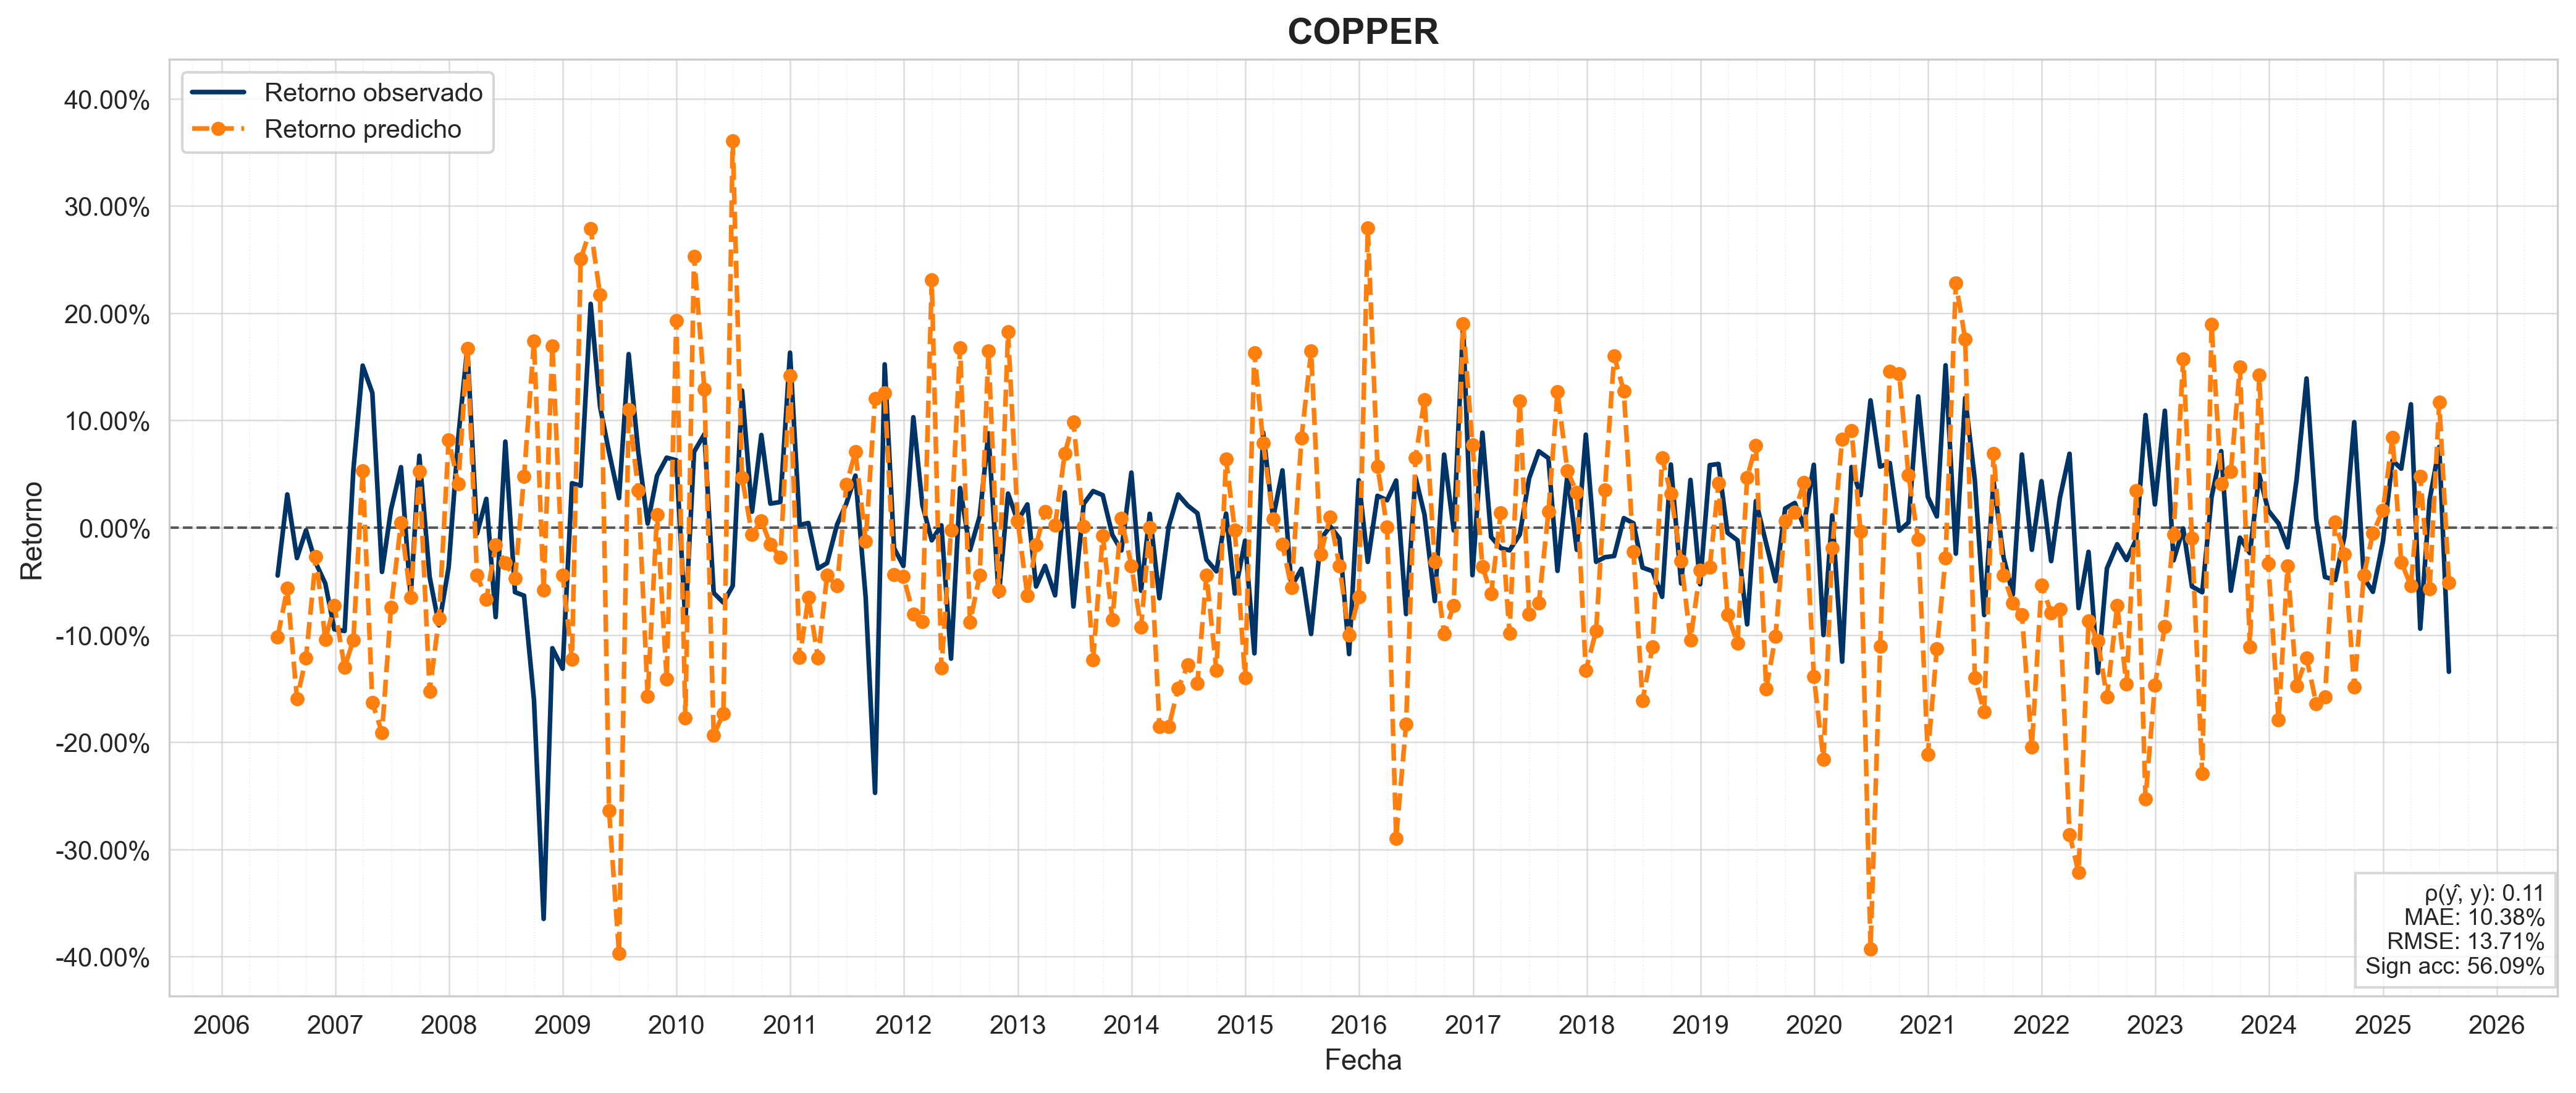

,"ARX-GARCH(1,1) — rolling 1-step"
SIGNO,0.6136
asep_u_stat,2.1557
asep_l_stat,1.0235
sep_stat,2.2228
ep_stat,2.4665
cw_stat_FF,1.3918
Geo_mean_return,0.81%
Upper_geo_mean,1.53%
Lower_geo_mean,0.36%


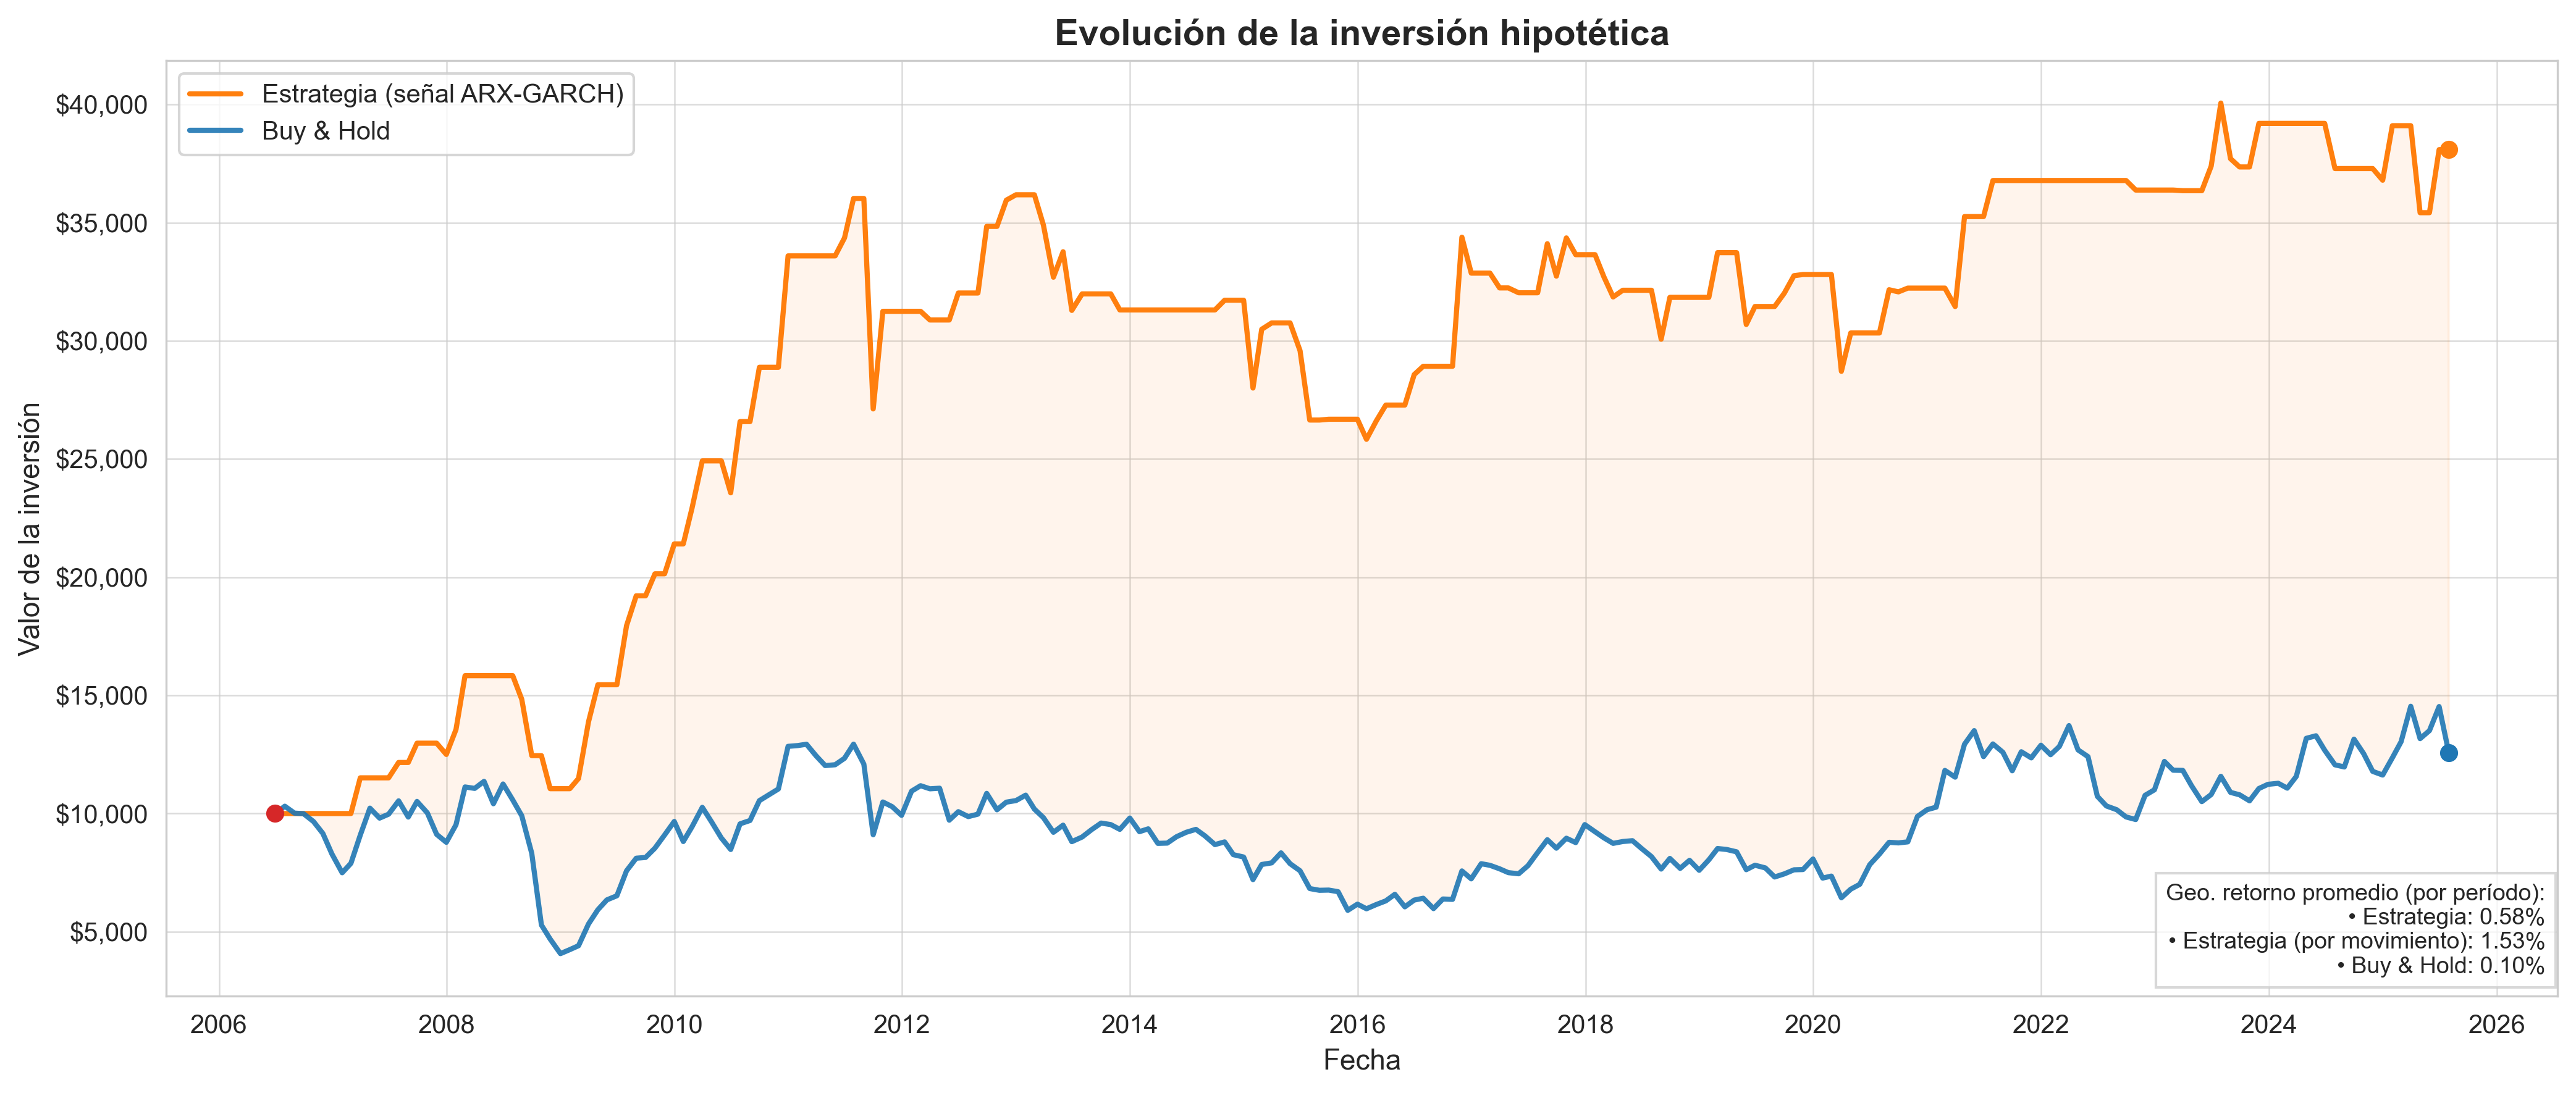

In [ ]:
DF = DF_RENT[["R1_Copper_G1", "R1_AUD/USD", "R1_NZD/USD","R1_CLP/USD","R1_CAD/USD","R2_MSCI_Commodities","R8_CLP/USD"]]
Y = "R1_Copper_G1"
X = ["R1_AUD/USD", "R1_NZD/USD","R1_CLP/USD","R1_CAD/USD","R2_MSCI_Commodities","R8_CLP/USD"]


out_full = run_upper_geo_pipeline(
    df=DF,
    target_col=Y,
    feature_cols=X,
    lags=[1,6,12],
    horizon=0,
    pr_ratio=3,         # P/R impuesta (deduce R y P dado T)
    test_start=None,       # alternativo: "2015-01-01"
    test_size=None,        # ignorado al usar pr_ratio
    cv_splits=2,
    scaler="standard",     # el estimador se entrena en espacio ESCALADO
    optimizer="lbfgs",      # intenta L-BFGS si SciPy está disponible
    base_kappa=8.0,
    anneal_schedule=(0.5, 1.0, 2.0, 4.0),
    pos_rate_target=0.3,
    pos_rate_weight=20.0,
    param_grid={
        "ugm__kappa": [2.0, 4.0, 8.0],
        "ugm__lam2": [1e-6, 1e-5, 1e-4],
        "ugm__pos_rate_target": [0.3, 0.4],
        "ugm__pos_rate_weight": [10.0, 20.0, 40.0],
    },
)
print("\n=== GRID SEARCH + TEST ===")
print("upper_geo_mean:", out_full["test_metrics"]["upper_geo_mean"])
# b0_orig, beta_orig = recover_original_params(out_full["best_model"])
print("β̂ (original):",np.round(out_full["beta_hat_original"], 6))

display(out_full["split_info"])
print(out_full["df_eval"].shape)

#Evaluation
hat_y = out_full["df_eval"]["eta_pred"]/100
true_y = out_full["df_eval"]["y_true"]

panel = pd.concat([true_y.rename("Y"), hat_y.rename("PRED_y")], axis=1).dropna()
val_dates = panel.index

#Graph True vs Predicted
pr = out_full["split_info"]["pr_ratio"]
kappa = 1/(pr+1)

Graph_Return_Comparison(true_y, hat_y, val_dates, title="COPPER")

#METRICS
display(Metrics(panel["Y"], panel["PRED_y"]))


#INVESMENT
simulate_investment_strategy(panel["PRED_y"], panel["Y"], val_dates, V_0=10000)

In [ ]:

DF = DF_RENT[["R1_Copper_G1", "R1_AUD/USD", "R1_NZD/USD","R1_CLP/USD","R1_CAD/USD","R2_MSCI_Commodities","R8_CLP/USD"]]
Y = "R1_Copper_G1"
X = ["R1_AUD/USD", "R1_NZD/USD","R1_CLP/USD","R1_CAD/USD","R2_MSCI_Commodities","R8_CLP/USD"]


# Daily re-estimation (business days), rolling 24 months
out_daily = rolling_geo_regression_calendar(
    df=DF,
    target_col="ret_target",
    lags=[1, 2, 5],
    window_type="rolling",
    train_window="24M",
    min_train="24M",
    rebalance_freq="B",
    scaler="standard",
    model_params=dict(
        kappa=8.0,
        lam2=1e-4,
        objective_side="upper",
        side_rate_target=0.35,
        side_rate_weight=20.0,
        optimizer="auto",
        warm_start=True,  # also set inside model
    ),
    warm_start=True,
    cap_floor=-0.999,
    raise_on_breach=True,
)
print("DAILY OOS metrics:", out_daily["metrics"])

print("\n=== GRID SEARCH + TEST ===")
print("upper_geo_mean:", out_full["test_metrics"]["upper_geo_mean"])
# b0_orig, beta_orig = recover_original_params(out_full["best_model"])
print("β̂ (original):",np.round(out_full["beta_hat_original"], 6))

display(out_full["split_info"])
print(out_full["df_eval"].shape)

#Evaluation
hat_y = out_full["df_eval"]["eta_pred"]/100
true_y = out_full["df_eval"]["y_true"]

panel = pd.concat([true_y.rename("Y"), hat_y.rename("PRED_y")], axis=1).dropna()
val_dates = panel.index

#Graph True vs Predicted
pr = out_full["split_info"]["pr_ratio"]
kappa = 1/(pr+1)

Graph_Return_Comparison(true_y, hat_y, val_dates, title="COPPER")

#METRICS
display(Metrics(panel["Y"], panel["PRED_y"]))


#INVESMENT
simulate_investment_strategy(panel["PRED_y"], panel["Y"], val_dates, V_0=10000)